In [388]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import joblib
import random
from scipy import stats


from sklearn.model_selection import train_test_split, KFold, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, KFold,  StratifiedShuffleSplit

from tqdm.notebook import tqdm ,tnrange
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [389]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [390]:
train

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18354,25366,city_103,0.920,Male,Has relevent experience,Full time course,Graduate,STEM,5,<10,Pvt Ltd,1,71,0
18355,25545,city_160,0.920,Male,No relevent experience,no_enrollment,Graduate,Humanities,15,50-99,Pvt Ltd,1,160,0
18356,11514,city_114,0.926,Male,Has relevent experience,no_enrollment,Masters,STEM,11,50-99,Pvt Ltd,3,18,0
18357,1689,city_75,0.939,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10/49,Pvt Ltd,3,41,0


In [391]:

# Python Method 1 : Displays Data Information :
# Need to convert float64 to int for Catboost Classifier
def display_data_information(data, data_types, dataframe_name):
    print(" Information of ",dataframe_name,": Rows = ",data.shape[0],"| Columns = ",data.shape[1],"\n")
    data.info()
    print("\n")
    for VARIABLE in data_types :
        data_type = data.select_dtypes(include=[ VARIABLE ]).dtypes
        if len(data_type) > 0 :
            print(str(len(data_type))+" "+VARIABLE+" Features\n"+str(data_type)+"\n"  )        

# Display Data Information of "train" :

data_types  = ["float32","float64","int32","int64","object","category","datetime64[ns]"]
display_data_information(train, data_types, "train")

 Information of  train : Rows =  18359 | Columns =  14 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18359 entries, 0 to 18358
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             18359 non-null  int64  
 1   city                    18359 non-null  object 
 2   city_development_index  18359 non-null  float64
 3   gender                  14261 non-null  object 
 4   relevent_experience     18359 non-null  object 
 5   enrolled_university     18017 non-null  object 
 6   education_level         17902 non-null  object 
 7   major_discipline        15521 non-null  object 
 8   experience              18300 non-null  object 
 9   company_size            13580 non-null  object 
 10  company_type            13320 non-null  object 
 11  last_new_job            17992 non-null  object 
 12  training_hours          18359 non-null  int64  
 13  target                  18359 non-

In [392]:
def display_head_tail(data, head_rows, tail_rows):
    display("Data Head & Tail :")
    display(data.head(head_rows).append(data.tail(tail_rows)))
display_head_tail(train, 5, 5)

'Data Head & Tail :'

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1
18354,25366,city_103,0.920,Male,Has relevent experience,Full time course,Graduate,STEM,5,<10,Pvt Ltd,1,71,0
18355,25545,city_160,0.920,Male,No relevent experience,no_enrollment,Graduate,Humanities,15,50-99,Pvt Ltd,1,160,0
18356,11514,city_114,0.926,Male,Has relevent experience,no_enrollment,Masters,STEM,11,50-99,Pvt Ltd,3,18,0
18357,1689,city_75,0.939,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10/49,Pvt Ltd,3,41,0
18358,5995,city_105,0.794,Female,Has relevent experience,no_enrollment,Graduate,STEM,>20,100-500,Pvt Ltd,2,84,0


In [393]:
# Python Method 3 : Displays Data Description using Statistics :

def display_data_description(data, numeric_data_types, categorical_data_types):
    
    print("Data Description :")
    display(data.describe( include = numeric_data_types))
    print("")
    display(data.describe( include = categorical_data_types))

# Display Data Description of "train" :
data_types  = ["float32","float64","int32","int64","object","category","datetime64[ns]"]

display_data_description(train, data_types[0:4], data_types[4:7])

Data Description :


,enrollee_id,city_development_index,training_hours,target
count,18359.000000,18359.000000,18359.000000,18359.000000
mean,16729.360096,0.847140,65.899014,0.132088
std,9643.749725,0.110189,60.885300,0.338595
min,1.000000,0.448000,1.000000,0.000000
25%,8378.500000,0.796000,23.000000,0.000000
50%,16706.000000,0.910000,47.000000,0.000000
75%,25148.500000,0.920000,89.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,18359,14261,18359,18017,17902,15521,18300,13580,13320,17992
unique,123,3,2,3,5,6,22,8,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1
freq,4358,12884,13596,13659,10769,13738,3437,3120,10051,7567


In [394]:
# Python Method 4 : Removes Data Duplicates while Retaining the First one - Similar to SQL DISTINCT :
# All rows are unique
def remove_duplicate(data):
    
    print("BEFORE REMOVING DUPLICATES - No. of Rows = ",data.shape[0])
    data.drop_duplicates(keep="first", inplace=True) 
    print("AFTER REMOVING DUPLICATES  - No. of Rows = ",data.shape[0])
    
    return data
remove_duplicate(train)

BEFORE REMOVING DUPLICATES - No. of Rows =  18359
AFTER REMOVING DUPLICATES  - No. of Rows =  18359


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18354,25366,city_103,0.920,Male,Has relevent experience,Full time course,Graduate,STEM,5,<10,Pvt Ltd,1,71,0
18355,25545,city_160,0.920,Male,No relevent experience,no_enrollment,Graduate,Humanities,15,50-99,Pvt Ltd,1,160,0
18356,11514,city_114,0.926,Male,Has relevent experience,no_enrollment,Masters,STEM,11,50-99,Pvt Ltd,3,18,0
18357,1689,city_75,0.939,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10/49,Pvt Ltd,3,41,0


In [395]:
# Python Method 5 : Displays Unique Values in Each Column of the Dataframe(Table) :

def display_unique(data):
    for column in data.columns :
        
        print("No of Unique Values in "+column+" Column are : "+str(data[column].nunique()))
#         print("Actual Unique Values in "+column+" Column are : "+str(data[column].sort_values(ascending=True,na_position='last').unique() ))
#         print("NULL Values :")
#         print(data[ column ].isnull().sum())
        print("Value Counts :")
        print(data[column].value_counts())
        print("")
        
# Displays Unique Values in Each Column of "train" :
# Check "train" data for Values of each Column - Long Form :

display_unique(train)

No of Unique Values in enrollee_id Column are : 18359
Value Counts :
2047     1
2660     1
31322    1
29275    1
19036    1
        ..
5336     1
31957    1
29908    1
19667    1
6147     1
Name: enrollee_id, Length: 18359, dtype: int64

No of Unique Values in city Column are : 123
Value Counts :
city_103    4358
city_21     1672
city_16     1654
city_114    1472
city_160     827
            ... 
city_111       3
city_129       3
city_121       3
city_171       2
city_140       1
Name: city, Length: 123, dtype: int64

No of Unique Values in city_development_index Column are : 93
Value Counts :
0.920    5185
0.624    1672
0.910    1654
0.926    1472
0.698     655
         ... 
0.487       4
0.649       4
0.781       3
0.625       3
0.664       2
Name: city_development_index, Length: 93, dtype: int64

No of Unique Values in gender Column are : 3
Value Counts :
Male      12884
Female     1188
Other       189
Name: gender, dtype: int64

No of Unique Values in relevent_experience Column are

In [396]:
for i in train:
    print(f"column {i} unique values {train[i].unique()}")

column enrollee_id unique values [23798 29166    46 ... 11514  1689  5995]
column city unique values ['city_149' 'city_83' 'city_16' 'city_64' 'city_100' 'city_21' 'city_114'
 'city_103' 'city_97' 'city_160' 'city_65' 'city_90' 'city_75' 'city_136'
 'city_159' 'city_67' 'city_28' 'city_10' 'city_73' 'city_76' 'city_104'
 'city_27' 'city_30' 'city_61' 'city_99' 'city_41' 'city_142' 'city_9'
 'city_116' 'city_128' 'city_74' 'city_69' 'city_1' 'city_176' 'city_40'
 'city_123' 'city_152' 'city_165' 'city_89' 'city_36' 'city_44' 'city_46'
 'city_45' 'city_134' 'city_93' 'city_180' 'city_162' 'city_84' 'city_138'
 'city_173' 'city_19' 'city_71' 'city_158' 'city_23' 'city_102' 'city_105'
 'city_91' 'city_11' 'city_13' 'city_57' 'city_20' 'city_14' 'city_37'
 'city_115' 'city_50' 'city_167' 'city_12' 'city_143' 'city_126' 'city_77'
 'city_101' 'city_150' 'city_179' 'city_107' 'city_175' 'city_146'
 'city_98' 'city_166' 'city_118' 'city_129' 'city_127' 'city_24' 'city_81'
 'city_26' 'city_139' 

In [397]:
train.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4098
relevent_experience          0
enrolled_university        342
education_level            457
major_discipline          2838
experience                  59
company_size              4779
company_type              5039
last_new_job               367
training_hours               0
target                       0
dtype: int64

In [398]:
def fill_missing_values(data, fill_value, fill_types, columns, dataframe_name):
    
    print("Missing Values BEFORE REMOVAL in ",dataframe_name," data")
    display(data.isnull().sum())
    for column in columns :
        
        # Fill Missing Values with Specific Value :
        if "Value_Fill" in fill_types :
            data[ column ] = data[ column ].fillna(fill_value)
#             print("Value_Fill")

        # Fill Missing Values with Forward Fill  (Previous Row Value as Current Row in Table) :
        if "Forward_Fill" in fill_types :
            data[ column ] = data[ column ].ffill(axis = 0)
#             print("Forward_Fill")

        # Fill Missing Values with Backward Fill (Next Row Value as Current Row in Table) :
        if "Backward_Fill" in fill_types :
            data[ column ] = data[ column ].bfill(axis = 0)
#             print("Backward_Fill")
    
    print("Missing Values AFTER REMOVAL in ",dataframe_name," data")
    display(data.isnull().sum())
    
    return data

In [399]:
fill_types = [ "Forward_Fill", "Value_Fill", "Backward_Fill"]
fill_value_gender = "Male"
fill_value_enrollment = train['enrolled_university'].mode()[0]
fill_value_education = train['education_level'].mode()[0]
fill_value_major_discipline = train['major_discipline'].mode()[0]
fill_value_experience = train['experience'].mode()[0]
fill_value_csize = train['company_size'].mode()[0]
fill_value_ctype = train['company_type'].mode()[0]
fill_value_lastjob = train['last_new_job'].mode()[0]

# Fills or Imputes Missing values in "Registration_Date" Column with "Forward_Fill" Method in "train" : 
train = fill_missing_values(train, fill_value_gender, fill_types[2], ["gender"],"train")
train = fill_missing_values(train, fill_value_enrollment, fill_types[2], ["enrolled_university"],"train")
train = fill_missing_values(train, fill_value_education, fill_types[2], ["education_level"],"train")
train = fill_missing_values(train, fill_value_major_discipline, fill_types[2], ["major_discipline"],"train")
train = fill_missing_values(train, fill_value_experience, fill_types[2], ["experience"],"train")
train = fill_missing_values(train, fill_value_csize, fill_types[2], ["company_size"],"train")
train = fill_missing_values(train, fill_value_ctype, fill_types[2], ["company_type"],"train")
train = fill_missing_values(train, fill_value_lastjob, fill_types[2], ["last_new_job"],"train")


test = fill_missing_values(test, fill_value_gender, fill_types[2], ["gender"],"train")
test = fill_missing_values(test, fill_value_enrollment, fill_types[2], ["enrolled_university"],"train")
test = fill_missing_values(test, fill_value_education, fill_types[2], ["education_level"],"train")
test = fill_missing_values(test, fill_value_major_discipline, fill_types[2], ["major_discipline"],"train")
test = fill_missing_values(test, fill_value_experience, fill_types[2], ["experience"],"train")
test = fill_missing_values(test, fill_value_csize, fill_types[2], ["company_size"],"train")
test = fill_missing_values(test, fill_value_ctype, fill_types[2], ["company_type"],"train")
test = fill_missing_values(test, fill_value_lastjob, fill_types[2], ["last_new_job"],"train")

Missing Values BEFORE REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                    4098
relevent_experience          0
enrolled_university        342
education_level            457
major_discipline          2838
experience                  59
company_size              4779
company_type              5039
last_new_job               367
training_hours               0
target                       0
dtype: int64

Missing Values AFTER REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university        342
education_level            457
major_discipline          2838
experience                  59
company_size              4779
company_type              5039
last_new_job               367
training_hours               0
target                       0
dtype: int64

Missing Values BEFORE REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university        342
education_level            457
major_discipline          2838
experience                  59
company_size              4779
company_type              5039
last_new_job               367
training_hours               0
target                       0
dtype: int64

Missing Values AFTER REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level            457
major_discipline          2838
experience                  59
company_size              4779
company_type              5039
last_new_job               367
training_hours               0
target                       0
dtype: int64

Missing Values BEFORE REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level            457
major_discipline          2838
experience                  59
company_size              4779
company_type              5039
last_new_job               367
training_hours               0
target                       0
dtype: int64

Missing Values AFTER REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline          2838
experience                  59
company_size              4779
company_type              5039
last_new_job               367
training_hours               0
target                       0
dtype: int64

Missing Values BEFORE REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline          2838
experience                  59
company_size              4779
company_type              5039
last_new_job               367
training_hours               0
target                       0
dtype: int64

Missing Values AFTER REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline             0
experience                  59
company_size              4779
company_type              5039
last_new_job               367
training_hours               0
target                       0
dtype: int64

Missing Values BEFORE REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline             0
experience                  59
company_size              4779
company_type              5039
last_new_job               367
training_hours               0
target                       0
dtype: int64

Missing Values AFTER REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline             0
experience                   0
company_size              4779
company_type              5039
last_new_job               367
training_hours               0
target                       0
dtype: int64

Missing Values BEFORE REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline             0
experience                   0
company_size              4779
company_type              5039
last_new_job               367
training_hours               0
target                       0
dtype: int64

Missing Values AFTER REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline             0
experience                   0
company_size                 0
company_type              5039
last_new_job               367
training_hours               0
target                       0
dtype: int64

Missing Values BEFORE REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline             0
experience                   0
company_size                 0
company_type              5039
last_new_job               367
training_hours               0
target                       0
dtype: int64

Missing Values AFTER REMOVAL in  train  data


enrollee_id                 0
city                        0
city_development_index      0
gender                      0
relevent_experience         0
enrolled_university         0
education_level             0
major_discipline            0
experience                  0
company_size                0
company_type                0
last_new_job              367
training_hours              0
target                      0
dtype: int64

Missing Values BEFORE REMOVAL in  train  data


enrollee_id                 0
city                        0
city_development_index      0
gender                      0
relevent_experience         0
enrolled_university         0
education_level             0
major_discipline            0
experience                  0
company_size                0
company_type                0
last_new_job              367
training_hours              0
target                      0
dtype: int64

Missing Values AFTER REMOVAL in  train  data


enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

Missing Values BEFORE REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                    3388
relevent_experience          0
enrolled_university        279
education_level            395
major_discipline          2393
experience                  44
company_size              4051
company_type              4330
last_new_job               304
training_hours               0
dtype: int64

Missing Values AFTER REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university        279
education_level            395
major_discipline          2393
experience                  44
company_size              4051
company_type              4330
last_new_job               304
training_hours               0
dtype: int64

Missing Values BEFORE REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university        279
education_level            395
major_discipline          2393
experience                  44
company_size              4051
company_type              4330
last_new_job               304
training_hours               0
dtype: int64

Missing Values AFTER REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level            395
major_discipline          2393
experience                  44
company_size              4051
company_type              4330
last_new_job               304
training_hours               0
dtype: int64

Missing Values BEFORE REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level            395
major_discipline          2393
experience                  44
company_size              4051
company_type              4330
last_new_job               304
training_hours               0
dtype: int64

Missing Values AFTER REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline          2393
experience                  44
company_size              4051
company_type              4330
last_new_job               304
training_hours               0
dtype: int64

Missing Values BEFORE REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline          2393
experience                  44
company_size              4051
company_type              4330
last_new_job               304
training_hours               0
dtype: int64

Missing Values AFTER REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline             1
experience                  44
company_size              4051
company_type              4330
last_new_job               304
training_hours               0
dtype: int64

Missing Values BEFORE REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline             1
experience                  44
company_size              4051
company_type              4330
last_new_job               304
training_hours               0
dtype: int64

Missing Values AFTER REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline             1
experience                   0
company_size              4051
company_type              4330
last_new_job               304
training_hours               0
dtype: int64

Missing Values BEFORE REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline             1
experience                   0
company_size              4051
company_type              4330
last_new_job               304
training_hours               0
dtype: int64

Missing Values AFTER REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline             1
experience                   0
company_size                 2
company_type              4330
last_new_job               304
training_hours               0
dtype: int64

Missing Values BEFORE REMOVAL in  train  data


enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline             1
experience                   0
company_size                 2
company_type              4330
last_new_job               304
training_hours               0
dtype: int64

Missing Values AFTER REMOVAL in  train  data


enrollee_id                 0
city                        0
city_development_index      0
gender                      0
relevent_experience         0
enrolled_university         0
education_level             0
major_discipline            1
experience                  0
company_size                2
company_type                2
last_new_job              304
training_hours              0
dtype: int64

Missing Values BEFORE REMOVAL in  train  data


enrollee_id                 0
city                        0
city_development_index      0
gender                      0
relevent_experience         0
enrolled_university         0
education_level             0
major_discipline            1
experience                  0
company_size                2
company_type                2
last_new_job              304
training_hours              0
dtype: int64

Missing Values AFTER REMOVAL in  train  data


enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          1
experience                0
company_size              2
company_type              2
last_new_job              1
training_hours            0
dtype: int64

In [400]:
test = test.fillna(1)

# Data Exploration

In [401]:
def data_distribution(data, feature):
    
    plt.figure(figsize = (20,5))

    plt.subplot(1,3,1)
    sns.kdeplot(data[feature], shade=True)

    plt.subplot(1,3,2)
    sns.distplot(data[feature])

    plt.subplot(1,3,3)
    sns.boxplot(data[feature], orient = 'vertical')

    print("Skewness : {}, Kurtosis : {}".format(data[feature].skew(), data[feature].kurtosis()))
    plt.show()

In [402]:
def univariate_analysis(data, feature):
    plt.figure(figsize=(25,15))
    plt.subplot(1, 2, 1)
    print("Number of ", feature)
    print(data[feature].value_counts())
    sns.countplot(x=feature, data=data)
    plt.title(feature+" Distribution")
    plt.xlabel(feature+" Type")
    plt.ylabel(feature+" Count")
    
    plt.subplot(1,2,2)
    labels = data[feature].unique()
    print(labels)
    number_of_colors = len(labels)

    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
    size = data[feature].value_counts()
    explode = [0, 0.1]
    plt.pie(size, colors=color, labels=labels, shadow=True, autopct='%.2f%%')
    plt.title(feature+' Type')
    plt.axis('off')
    plt.legend(loc='upper left', bbox_to_anchor = (1,1))
    plt.show()

In [403]:
def distribution(data, feature):
    plt.figure(figsize=(15,15))
    sns.countplot(data[feature], palette = 'hsv')
    plt.title('Distribution of '+feature)
    plt.show()

Number of  target
0    15934
1     2425
Name: target, dtype: int64
[0 1]


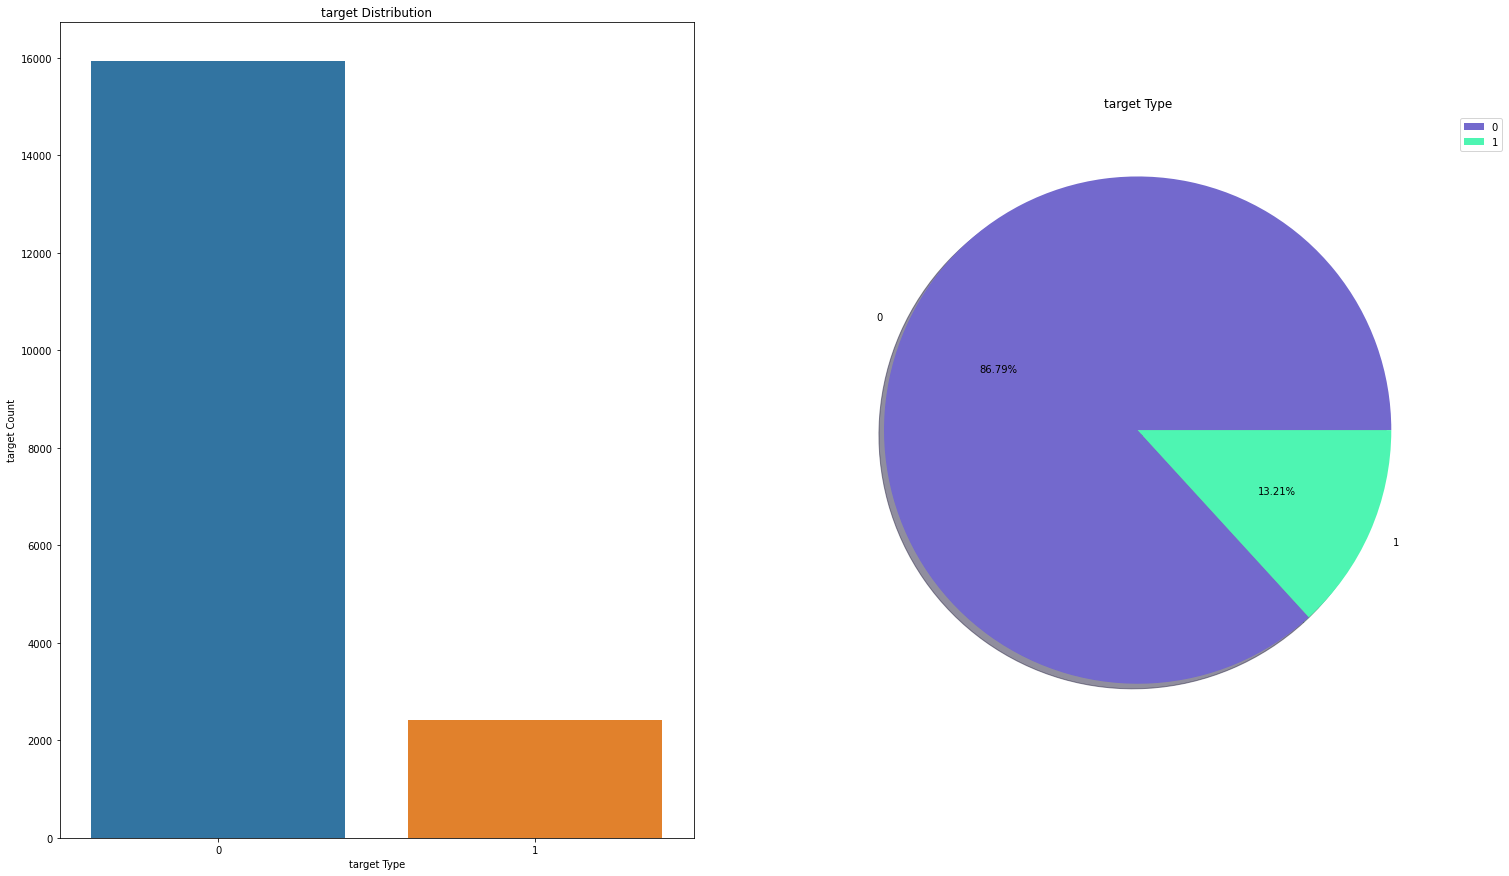

In [221]:
univariate_analysis(train, 'target')

Number of  gender
Male      16600
Female     1514
Other       245
Name: gender, dtype: int64
['Male' 'Female' 'Other']


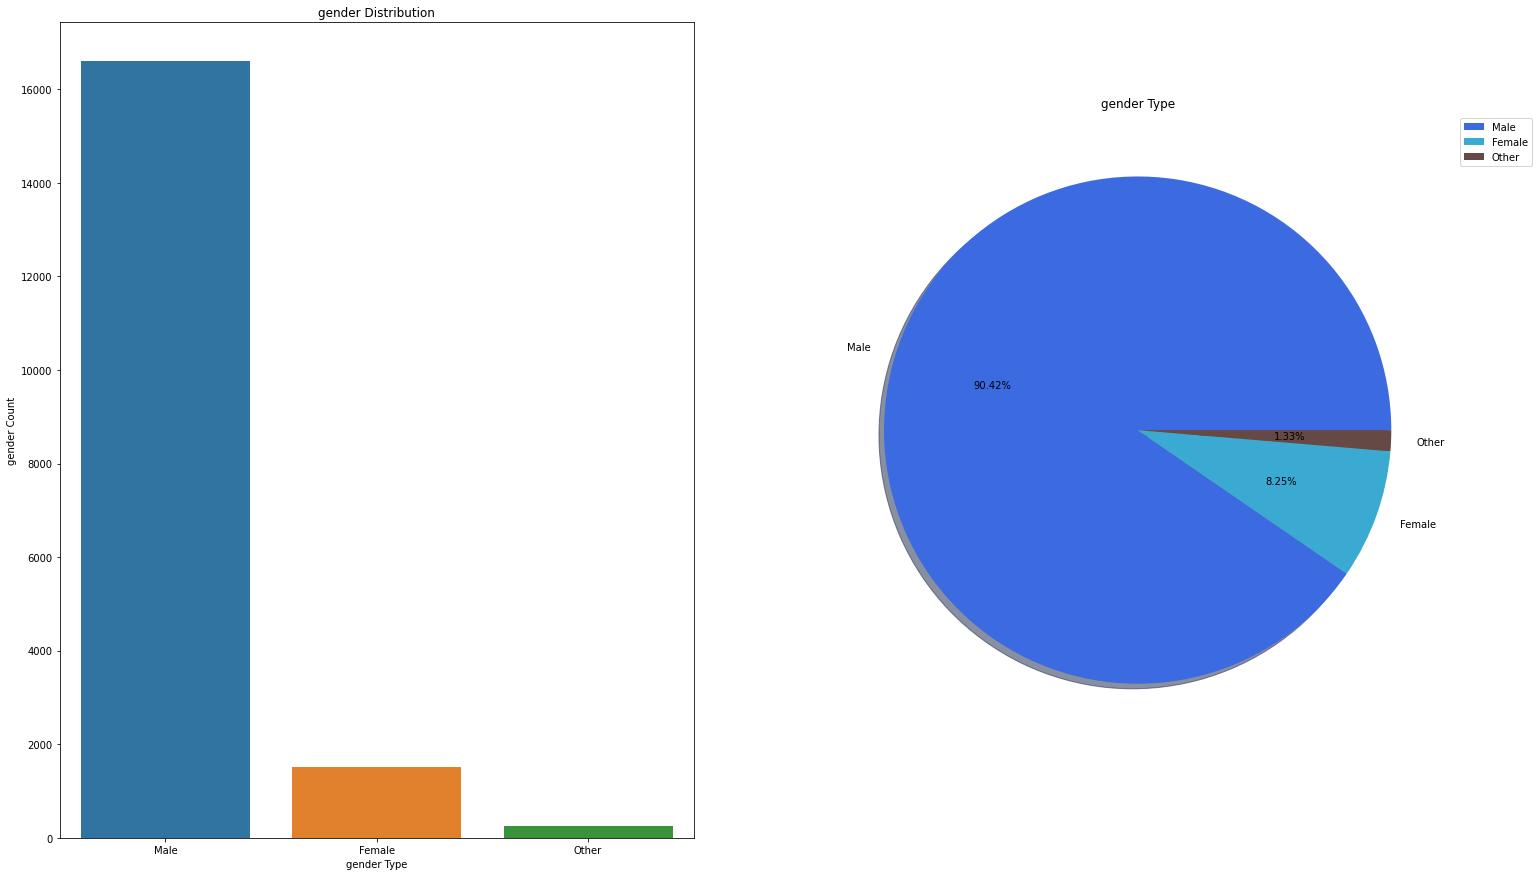

In [74]:
univariate_analysis(train, 'gender')

Number of  city
city_103    4358
city_21     1672
city_16     1654
city_114    1472
city_160     827
            ... 
city_121       3
city_111       3
city_129       3
city_171       2
city_140       1
Name: city, Length: 123, dtype: int64
['city_149' 'city_83' 'city_16' 'city_64' 'city_100' 'city_21' 'city_114'
 'city_103' 'city_97' 'city_160' 'city_65' 'city_90' 'city_75' 'city_136'
 'city_159' 'city_67' 'city_28' 'city_10' 'city_73' 'city_76' 'city_104'
 'city_27' 'city_30' 'city_61' 'city_99' 'city_41' 'city_142' 'city_9'
 'city_116' 'city_128' 'city_74' 'city_69' 'city_1' 'city_176' 'city_40'
 'city_123' 'city_152' 'city_165' 'city_89' 'city_36' 'city_44' 'city_46'
 'city_45' 'city_134' 'city_93' 'city_180' 'city_162' 'city_84' 'city_138'
 'city_173' 'city_19' 'city_71' 'city_158' 'city_23' 'city_102' 'city_105'
 'city_91' 'city_11' 'city_13' 'city_57' 'city_20' 'city_14' 'city_37'
 'city_115' 'city_50' 'city_167' 'city_12' 'city_143' 'city_126' 'city_77'
 'city_101' 'city_150' '

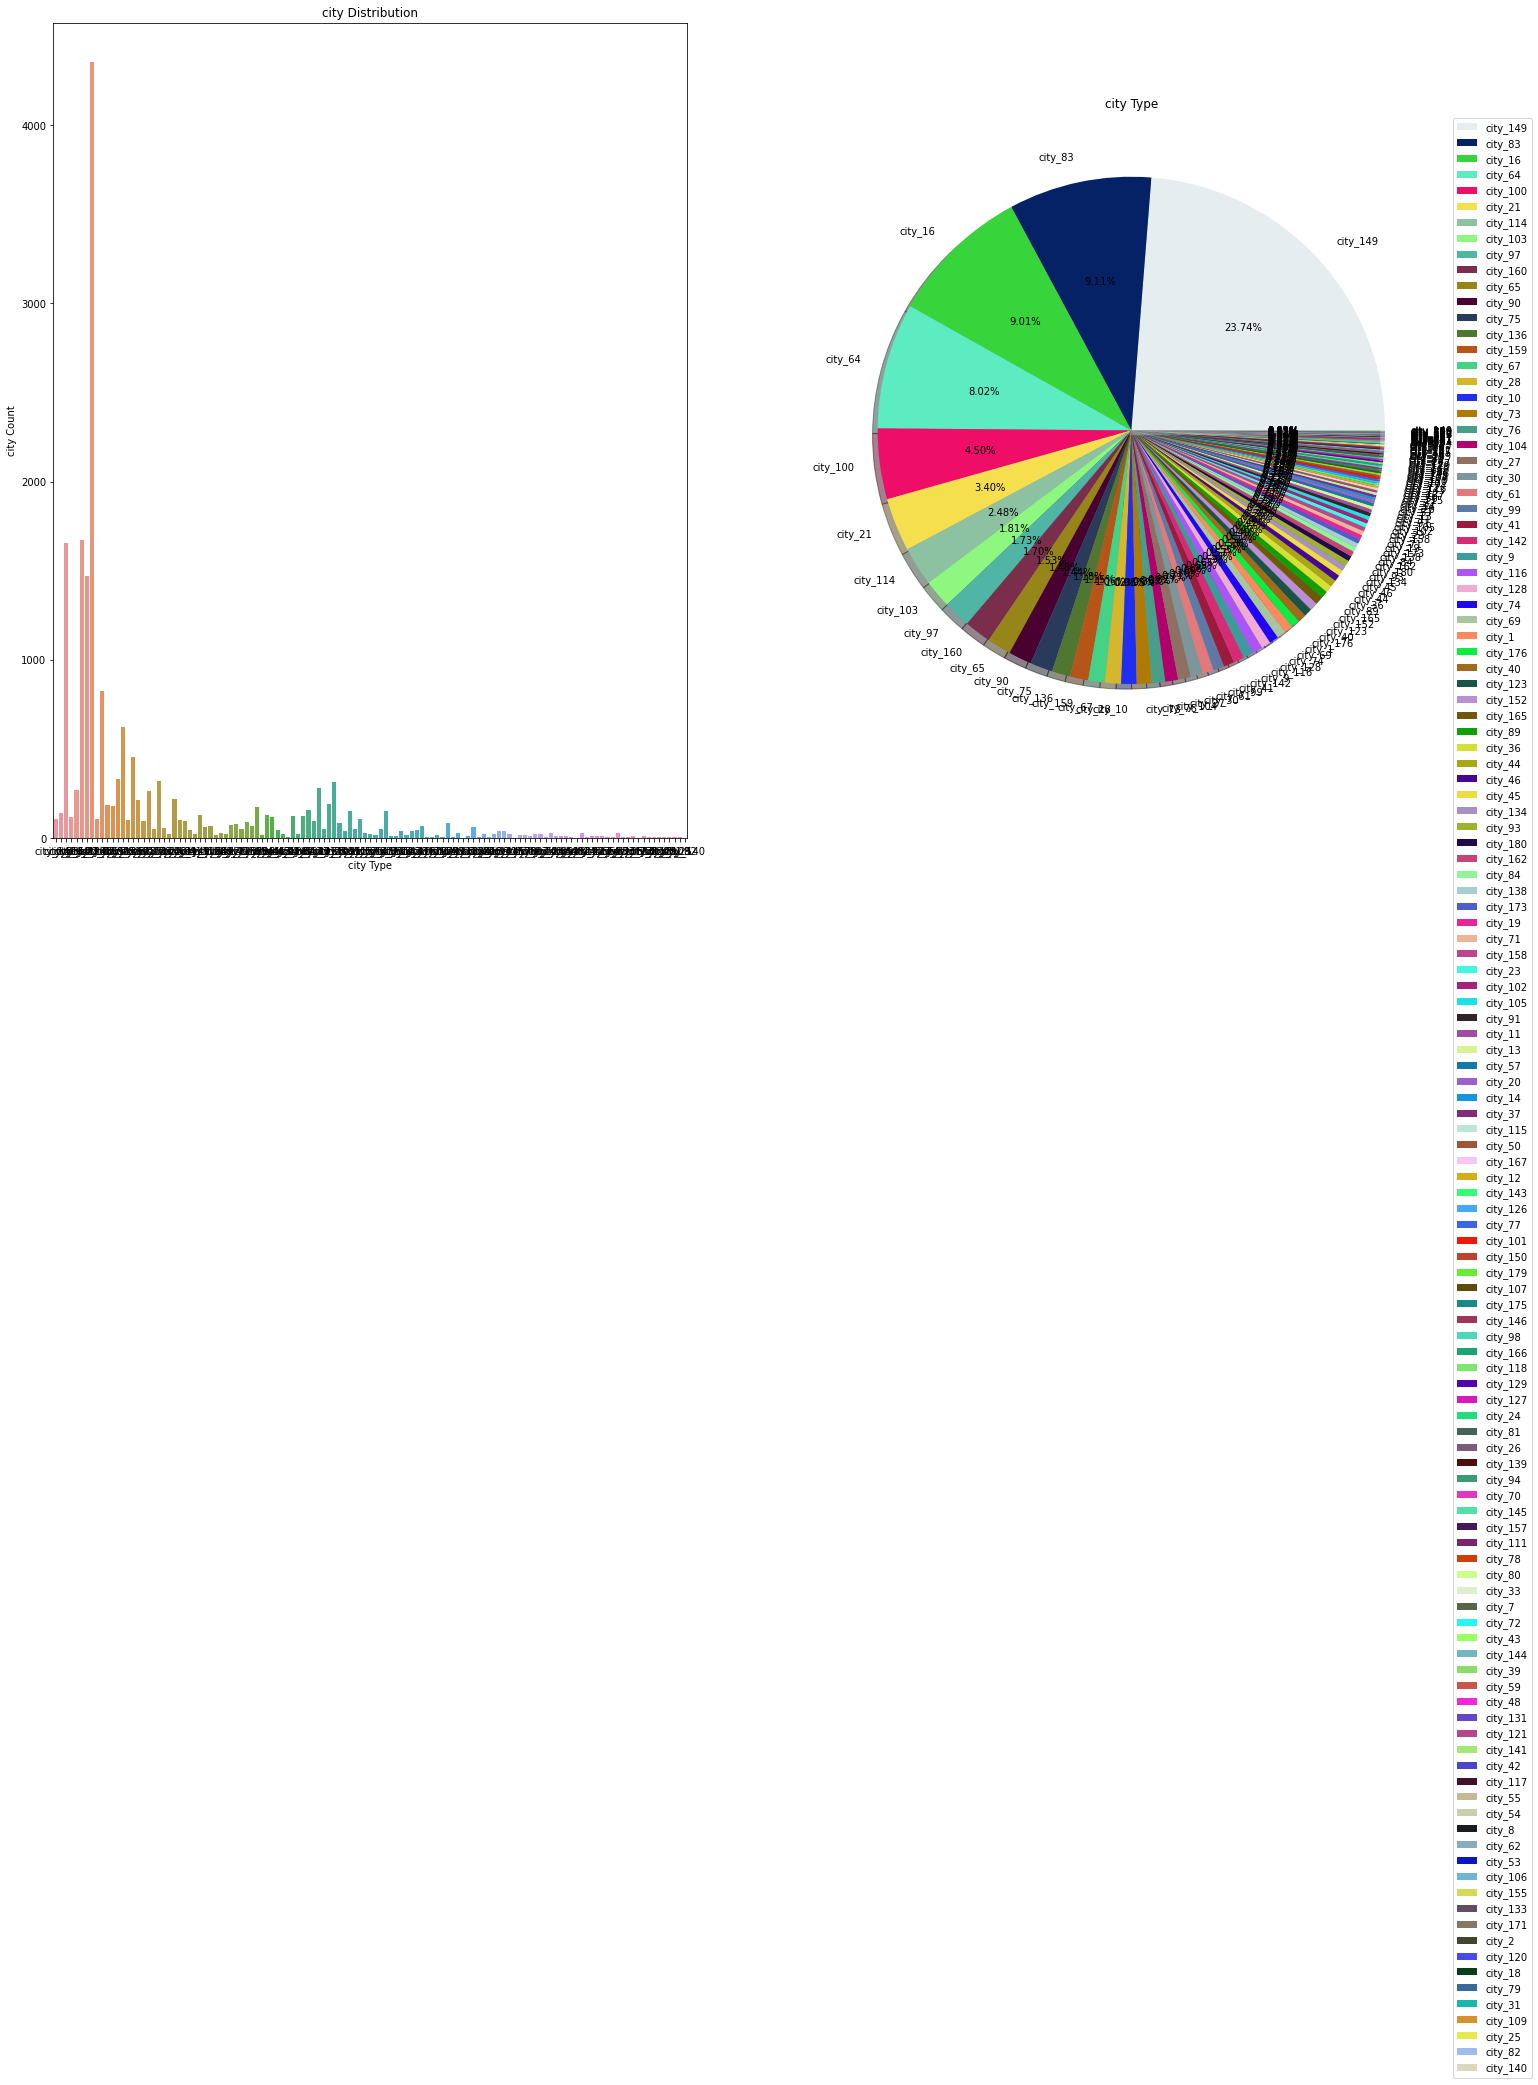

In [77]:
univariate_analysis(train, 'city')

Number of  relevent_experience
Has relevent experience    13596
No relevent experience      4763
Name: relevent_experience, dtype: int64
['Has relevent experience' 'No relevent experience']


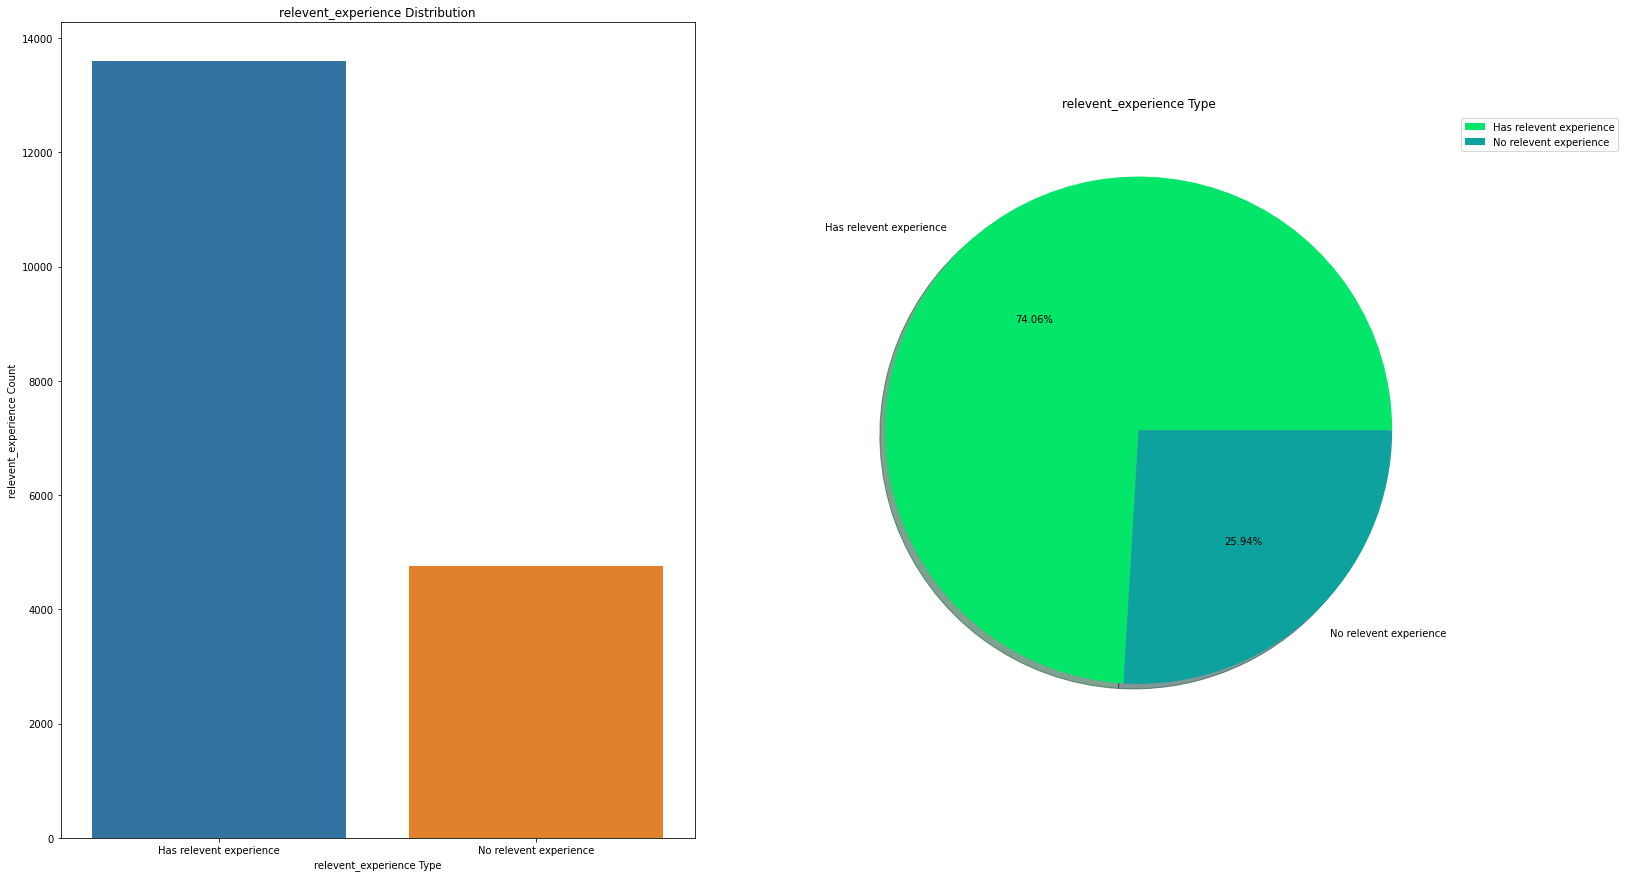

In [79]:
univariate_analysis(train, 'relevent_experience')

Number of  enrolled_university
no_enrollment       13926
Full time course     3239
Part time course     1194
Name: enrolled_university, dtype: int64
['no_enrollment' 'Full time course' 'Part time course']


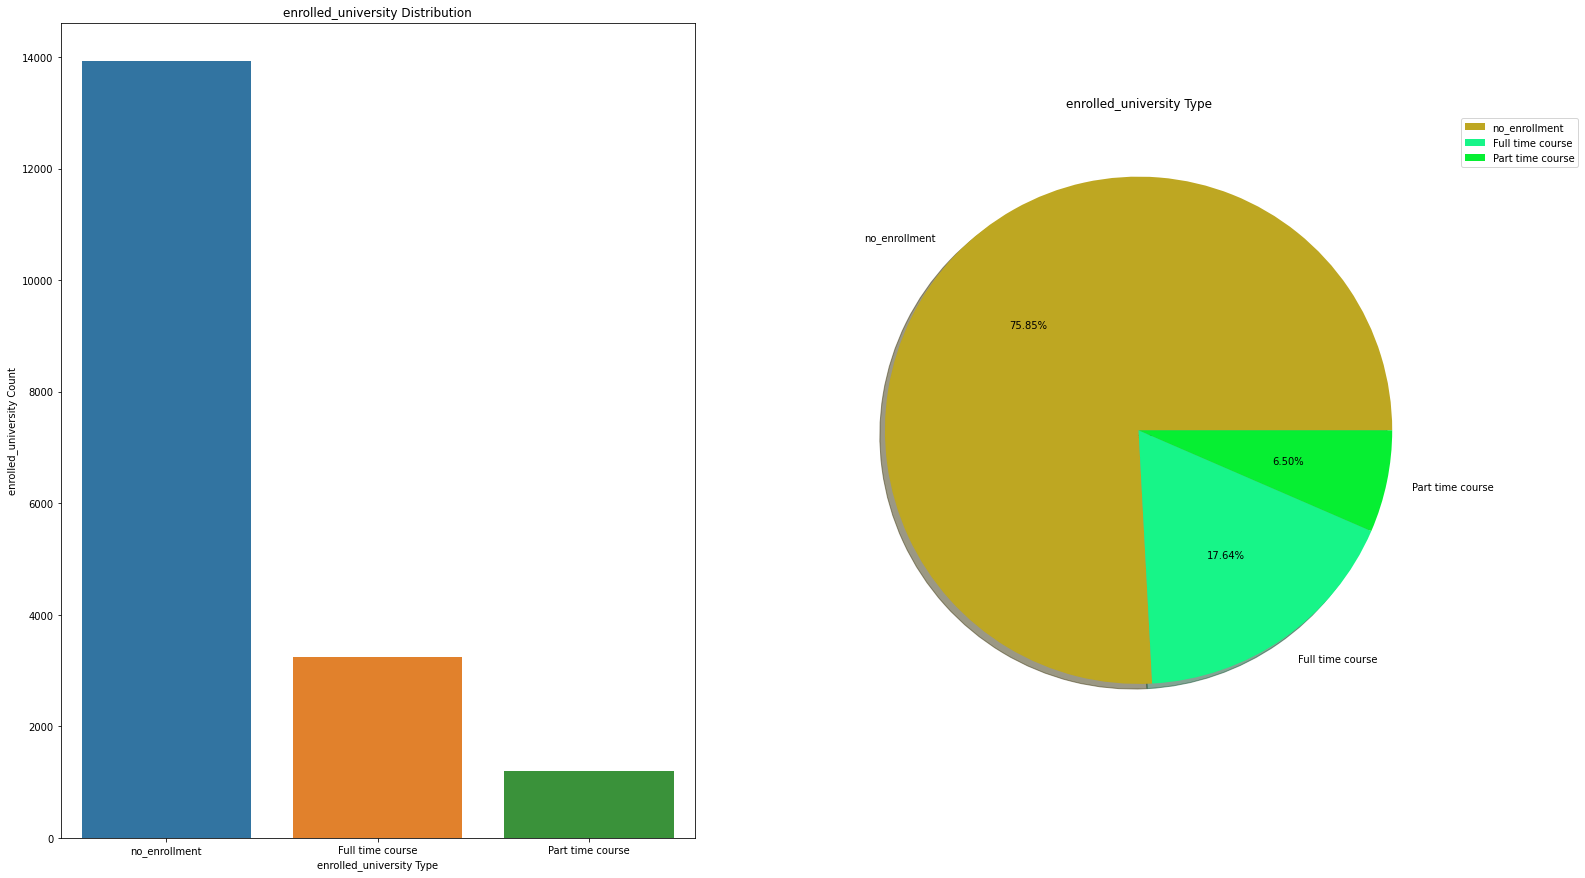

In [81]:
univariate_analysis(train, 'enrolled_university')

Number of  education_level
Graduate          11044
Masters            4428
High School        2082
Phd                 470
Primary School      335
Name: education_level, dtype: int64
['Graduate' 'Masters' 'High School' 'Phd' 'Primary School']


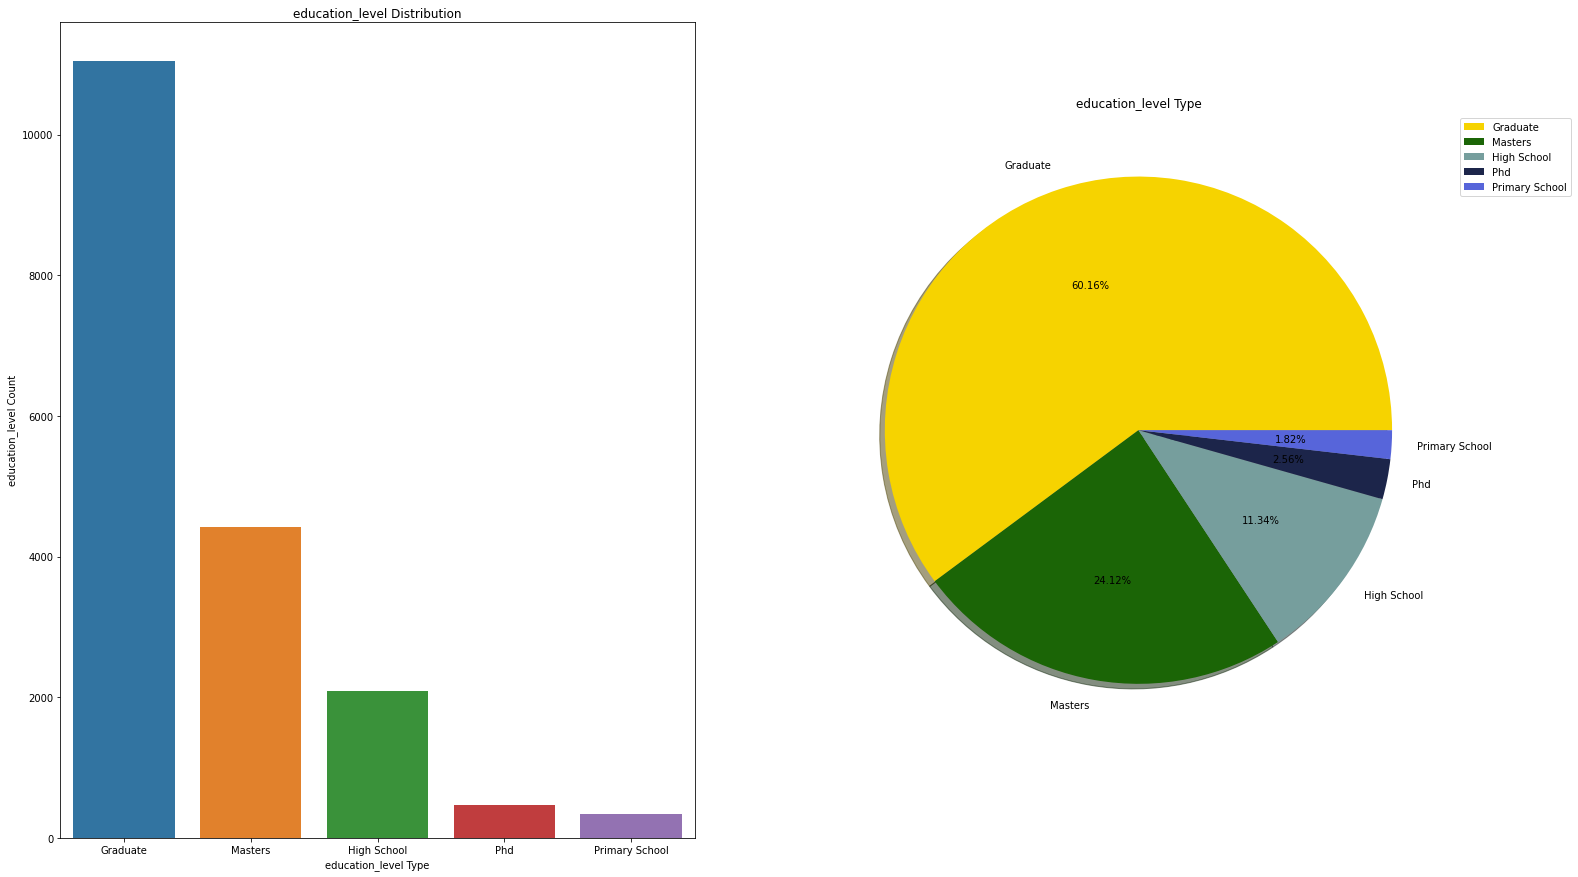

In [82]:
univariate_analysis(train, 'education_level')

Number of  major_discipline
STEM               16259
Humanities           813
Other                406
Business Degree      362
Arts                 285
No Major             234
Name: major_discipline, dtype: int64
['STEM' 'Other' 'No Major' 'Business Degree' 'Arts' 'Humanities']


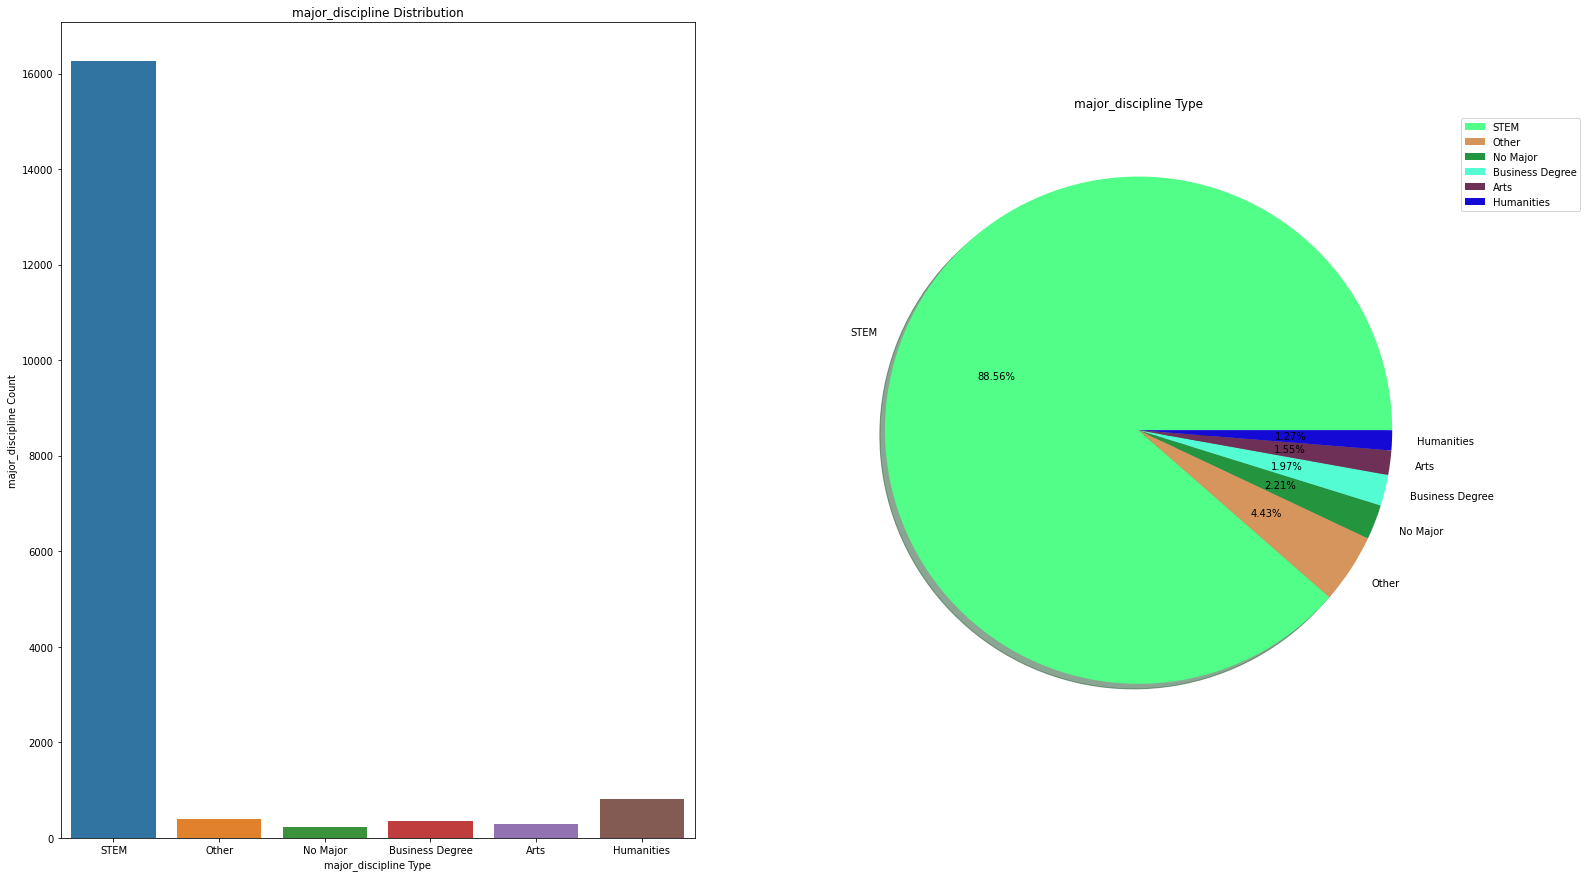

In [83]:
univariate_analysis(train, 'major_discipline')

Number of  experience
>20    3446
5      1314
4      1252
3      1165
6      1133
2       994
9       982
10      969
7       952
8       759
15      699
11      668
14      604
16      552
12      497
1       454
<1      416
13      414
17      347
19      309
18      286
20      147
Name: experience, dtype: int64
['3' '14' '6' '8' '>20' '4' '9' '15' '10' '1' '5' '16' '11' '12' '7' '2'
 '13' '<1' '19' '18' '17' '20']


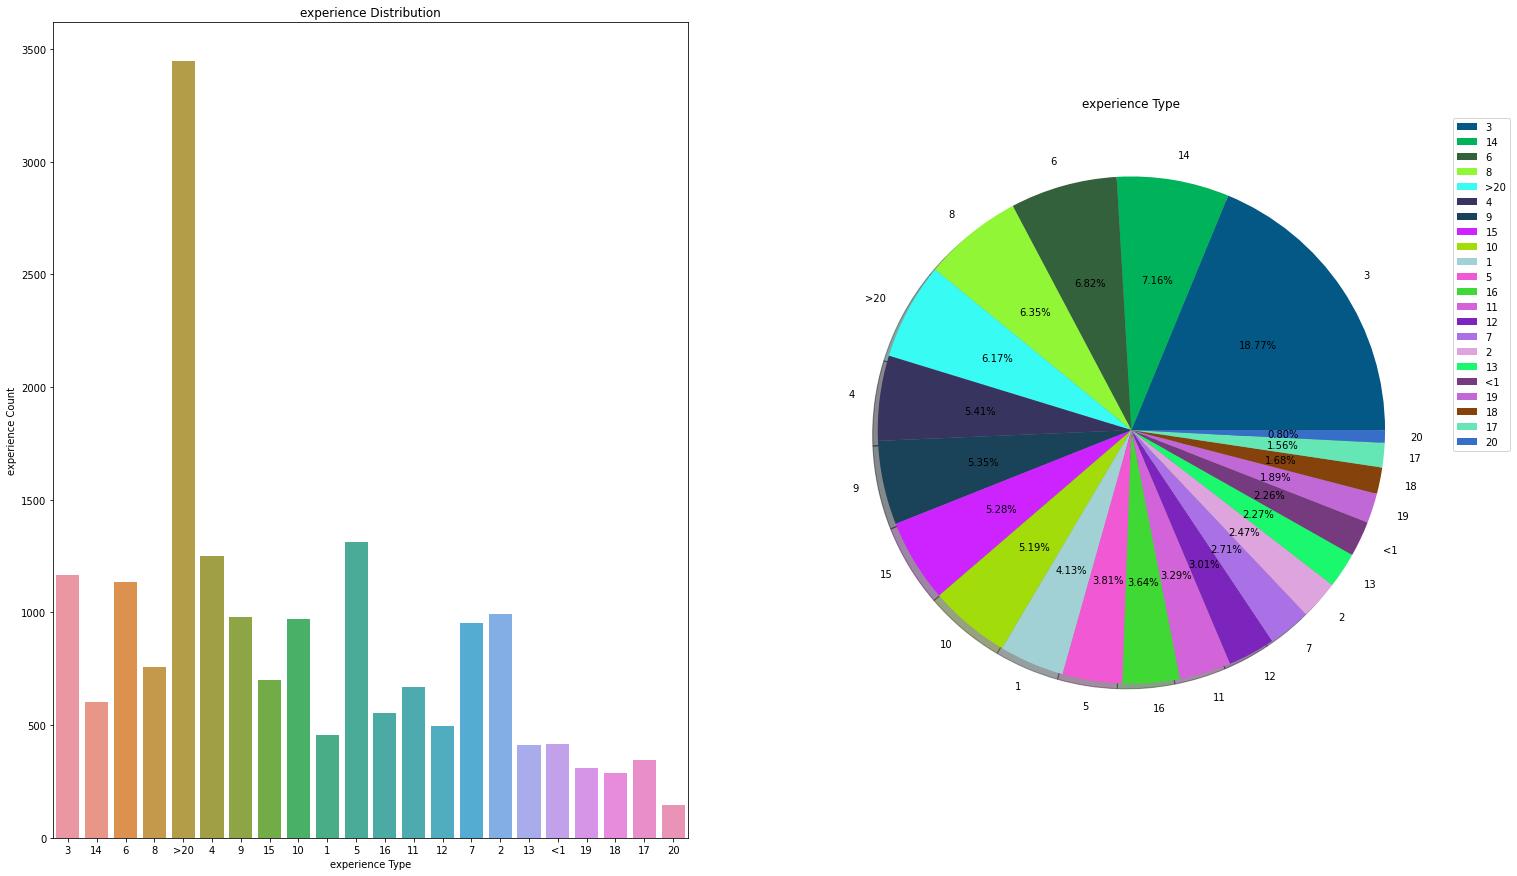

In [84]:
univariate_analysis(train, 'experience')

Number of  company_type
Pvt Ltd                13820
Public Sector           1427
Funded Startup          1407
Early Stage Startup      814
NGO                      725
Other                    166
Name: company_type, dtype: int64
['Pvt Ltd' 'Funded Startup' 'Public Sector' 'Early Stage Startup' 'NGO'
 'Other']


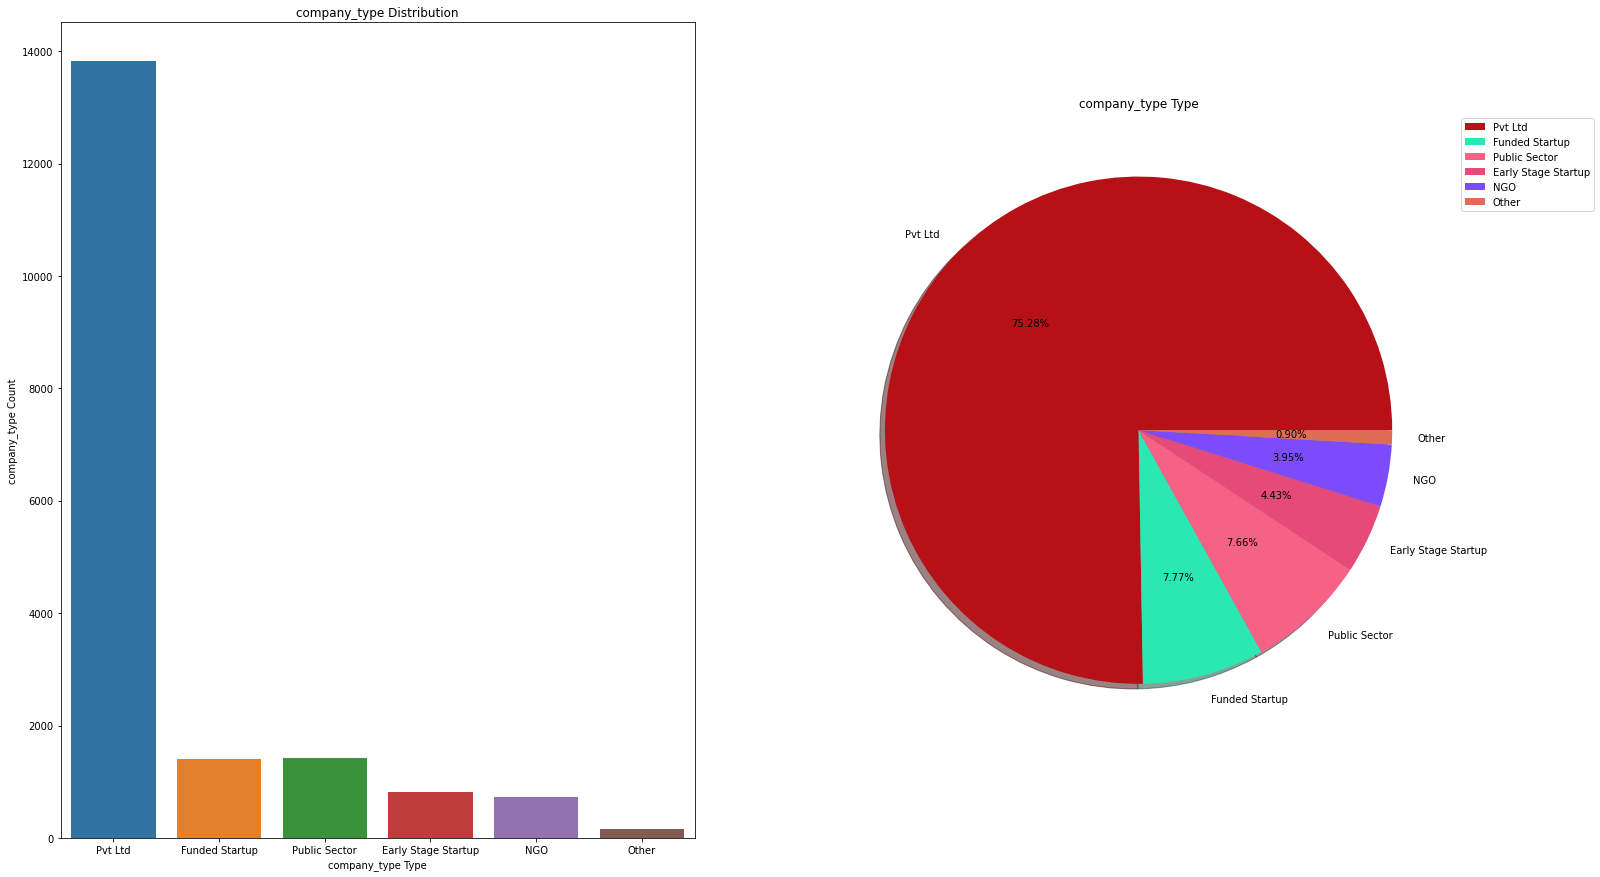

In [85]:
univariate_analysis(train, 'company_type')

Number of  company_size
50-99        4201
100-500      3704
10000+       2746
10/49        2000
1000-4999    1849
<10          1829
500-999      1244
5000-9999     786
Name: company_size, dtype: int64
['100-500' '<10' '50-99' '5000-9999' '10000+' '1000-4999' '500-999'
 '10/49']


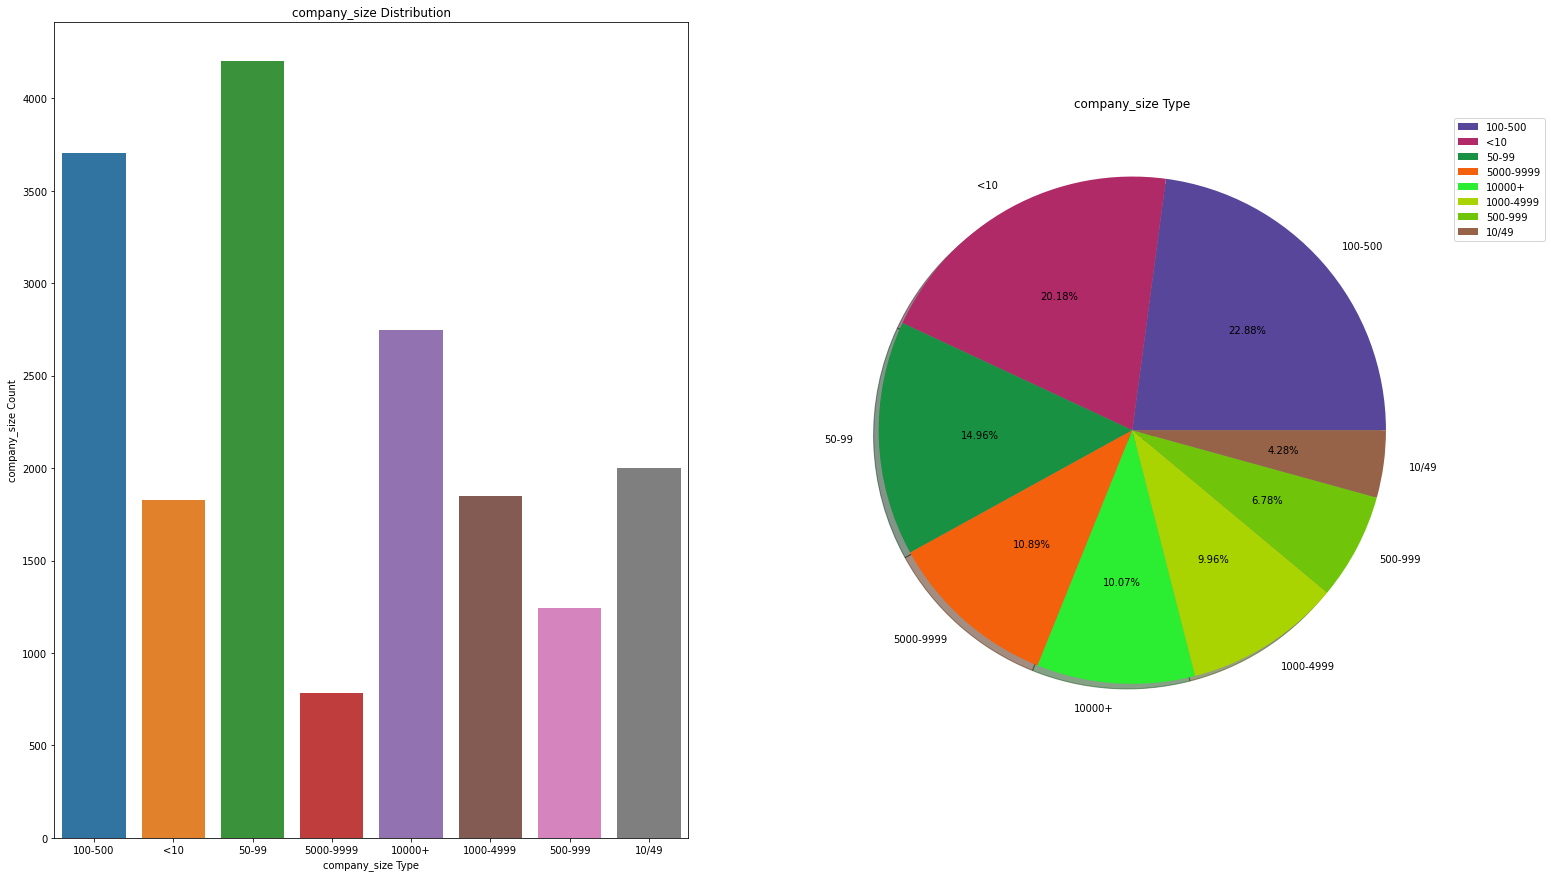

In [86]:
univariate_analysis(train, 'company_size')

Number of  last_new_job
1        7714
>4       3403
2        2894
never    2239
4        1058
3        1051
Name: last_new_job, dtype: int64
['1' '2' '3' '>4' 'never' '4']


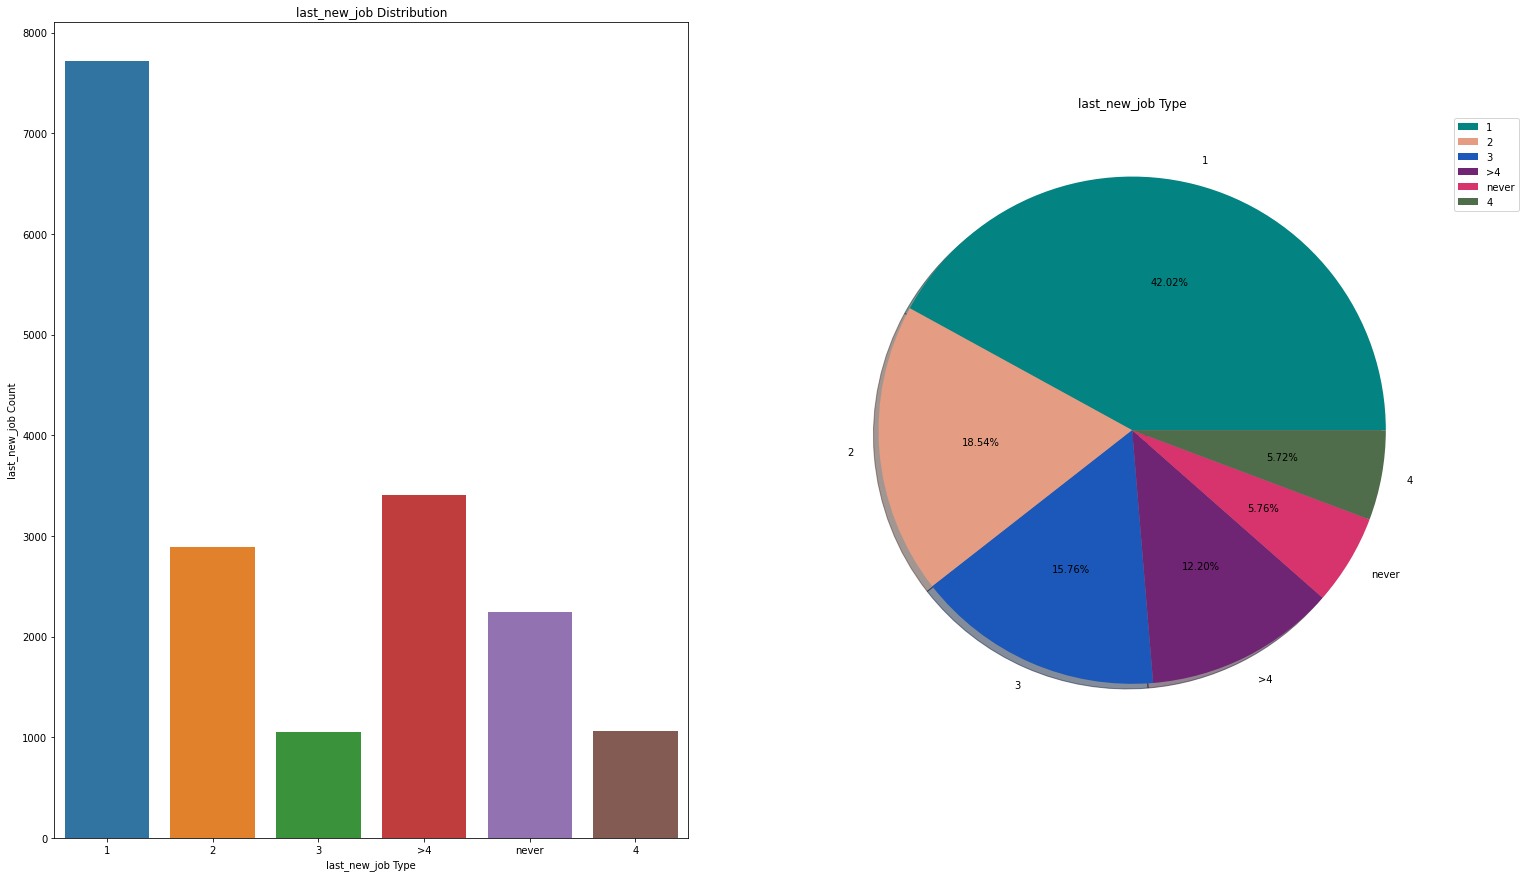

In [87]:
univariate_analysis(train, 'last_new_job')

Number of  training_hours
28     307
12     291
18     285
20     269
22     263
      ... 
244      6
234      6
272      5
238      4
286      4
Name: training_hours, Length: 241, dtype: int64
[106  69   4  26  88  34  23   8  10  85  55  13  51  28  35  42  45  11
  12  54  89  41 298 101 114 104  53  39  20 109   3  68 262  16  22  67
  43   7  30   9 112  21 166 110  18  79  98  65  61  44 170 132 145  48
  46  37  86  96  33 152 168 128 102   6  50  36  90 164  56  32  17 126
  72  15  80  25  31 160  66  24 200  47  83  58  29 206  14 105  91 218
  75  57  19 144  92  94 184  62 140  52 258 178 270 108 157 156 123  59
  82  60   2 196  95  84   5 146 202 100 111 254  27 336  64 107  76  38
 134 330 204 320  74  73  40  87 316 118 122 282 248 153 147  70 131 113
 216 292  81 176  78 222 163  63 280 210 294 264 155  77  97 224 180 236
 125 162 116 158 256  49  71 326   1 238 124 268 214 192 232 276 165 138
 310 167 288 117  99 198 240 119 136 139 150 266 220 172 133 284 272 312
 3

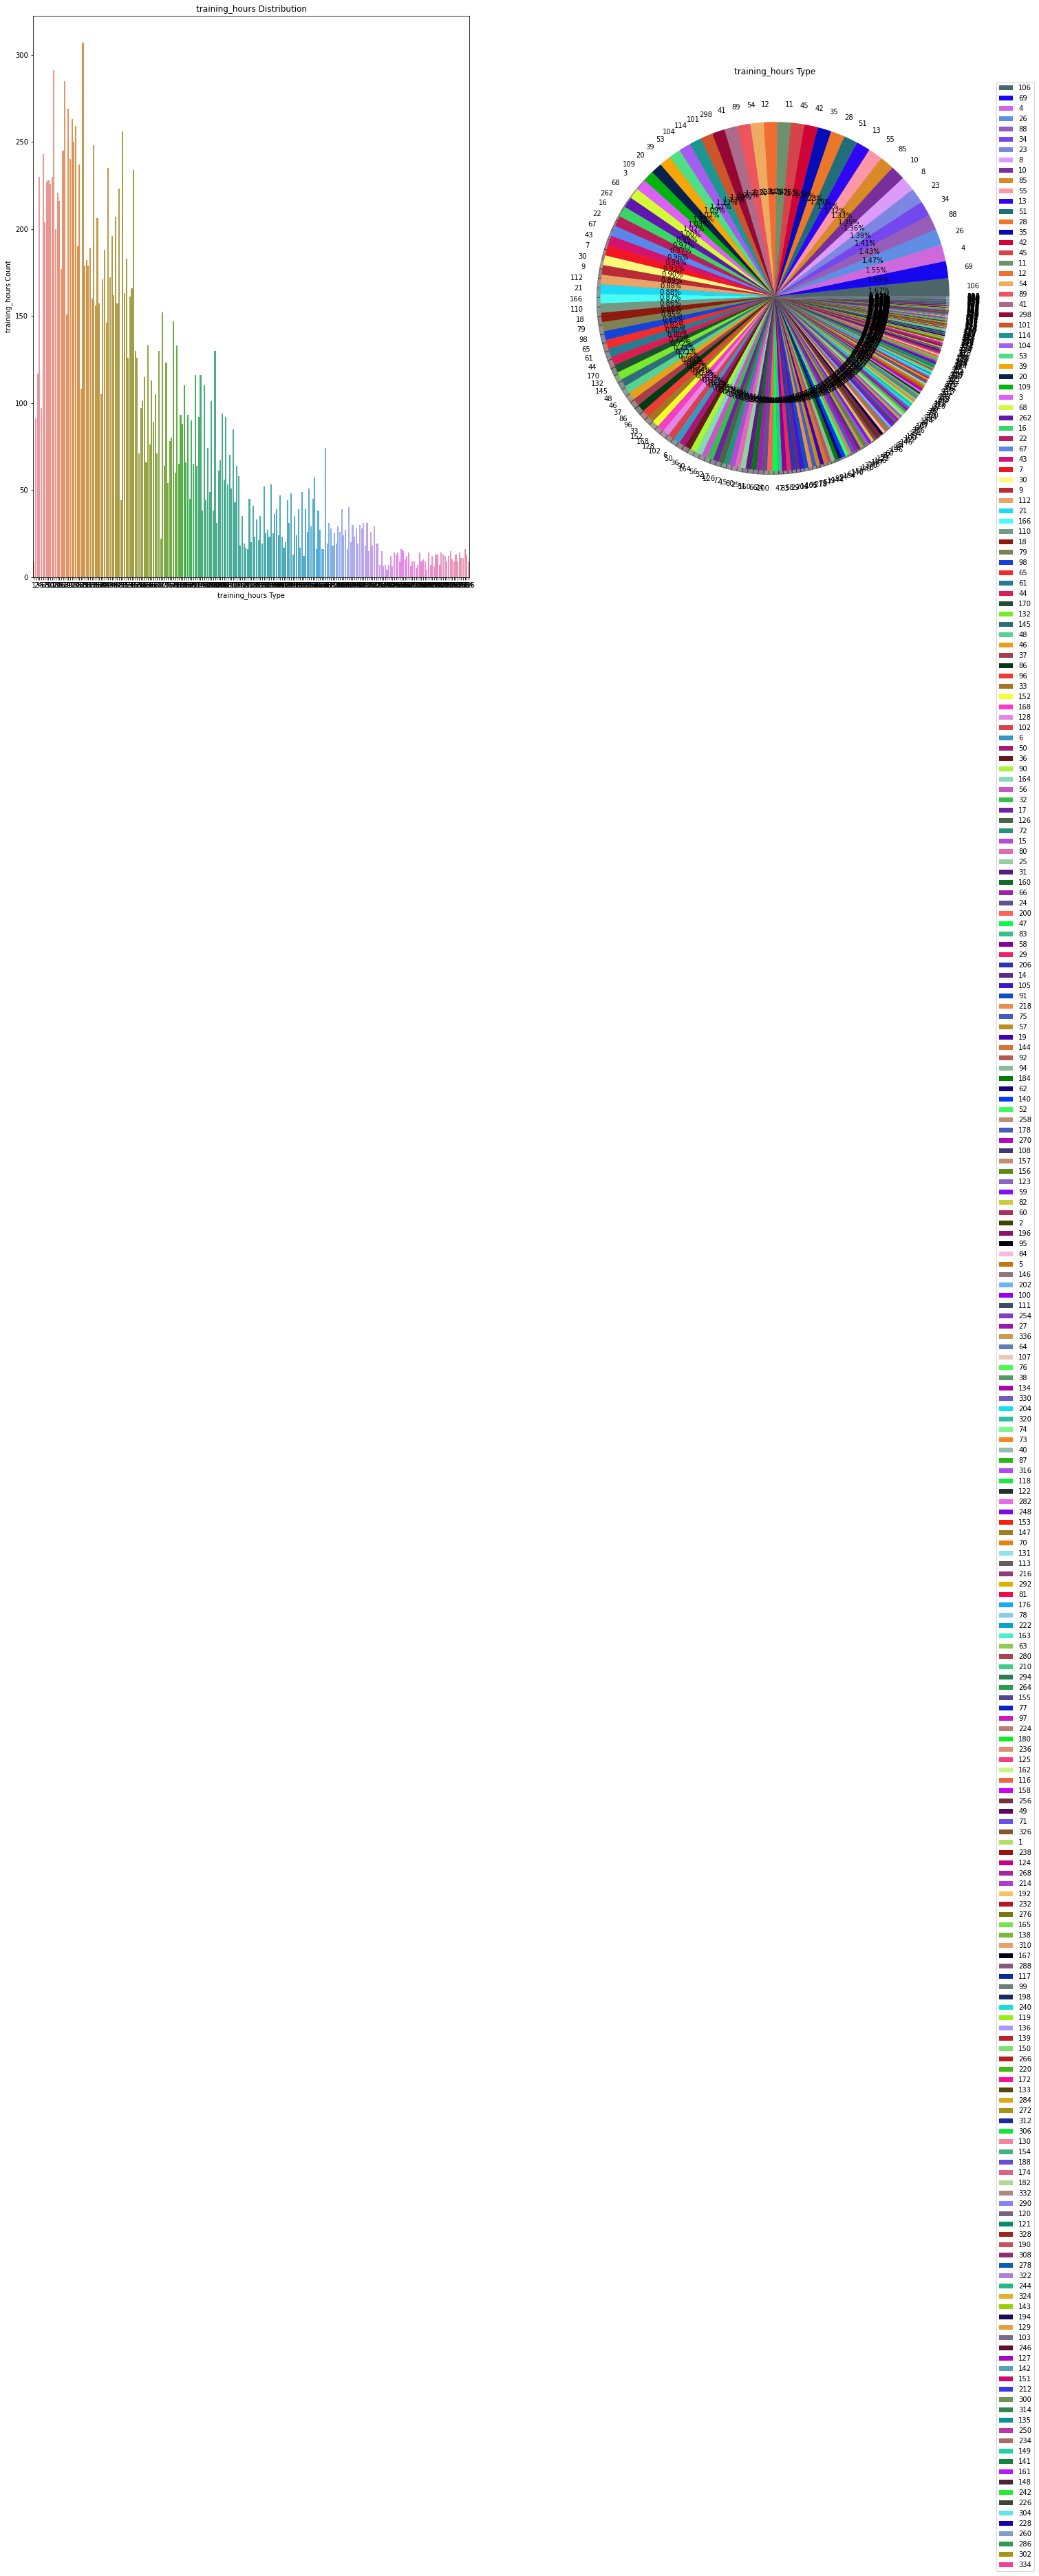

In [88]:
univariate_analysis(train, 'training_hours')

Number of  target
0    15934
1     2425
Name: target, dtype: int64
[0 1]


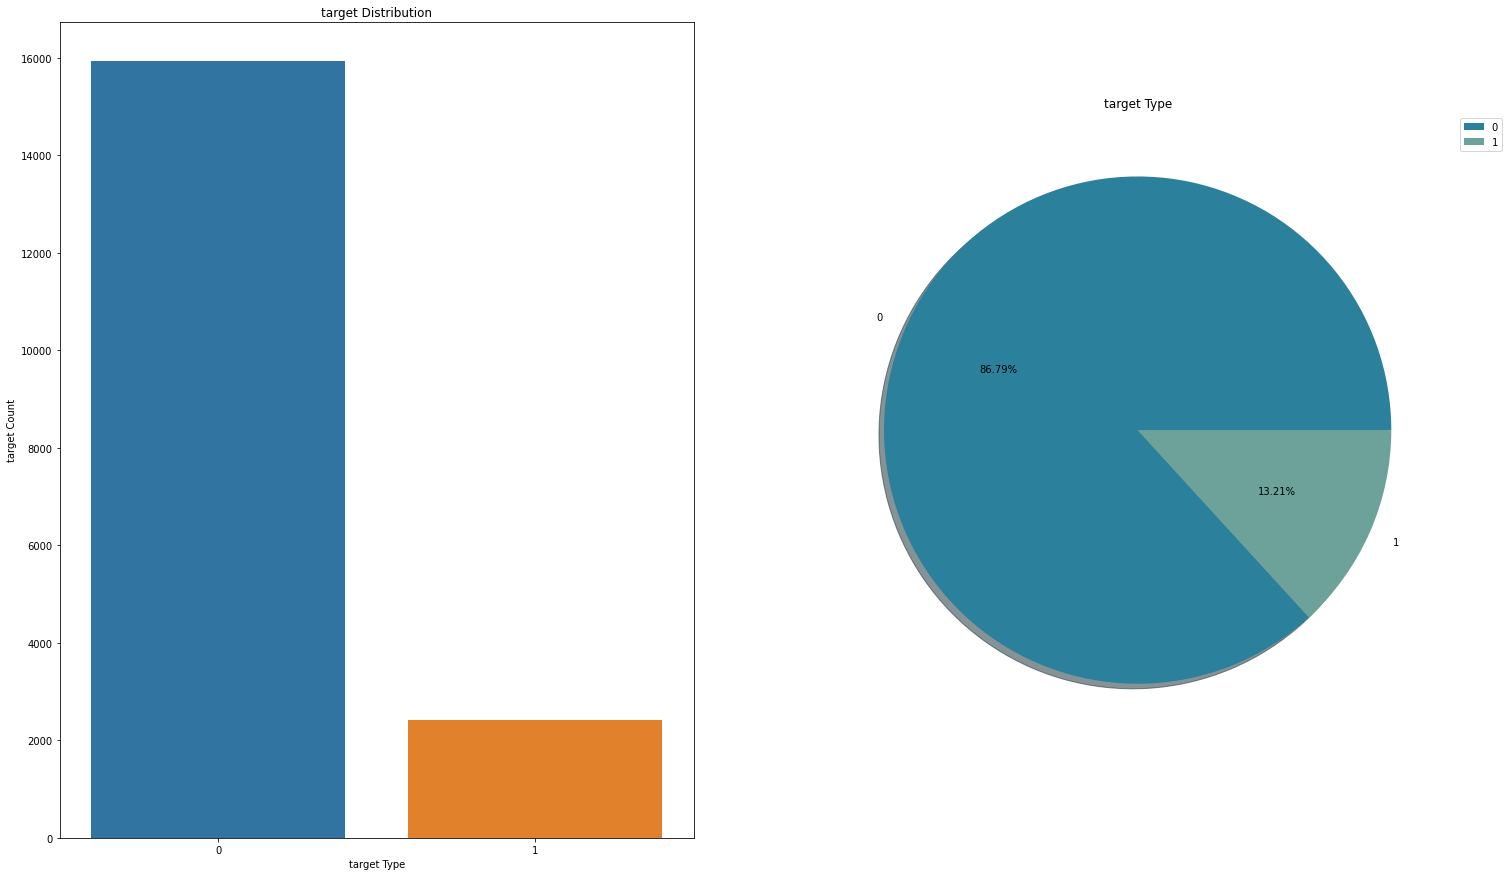

In [91]:
univariate_analysis(train, 'target')

# Distribution

-1.3273556661104728


-0.7164786922193864

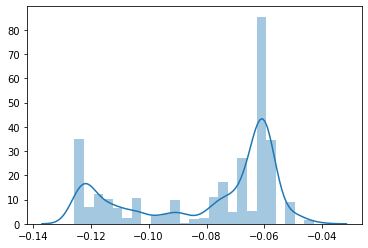

In [310]:
print(train['city_development_index'].skew())
crim = stats.boxcox(train['city_development_index'])[0]
sns.distplot(stats.boxcox(train['city_development_index'])[0])
pd.Series(crim).skew()

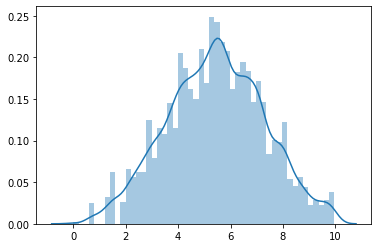

In [42]:
sns.distplot(stats.boxcox(train['training_hours'])[0])

# Feature Engineering

In [404]:
train.isna().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [405]:
train

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,Male,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,Female,No relevent experience,no_enrollment,Masters,STEM,8,5000-9999,Pvt Ltd,2,88,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18354,25366,city_103,0.920,Male,Has relevent experience,Full time course,Graduate,STEM,5,<10,Pvt Ltd,1,71,0
18355,25545,city_160,0.920,Male,No relevent experience,no_enrollment,Graduate,Humanities,15,50-99,Pvt Ltd,1,160,0
18356,11514,city_114,0.926,Male,Has relevent experience,no_enrollment,Masters,STEM,11,50-99,Pvt Ltd,3,18,0
18357,1689,city_75,0.939,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10/49,Pvt Ltd,3,41,0


In [406]:
train['city'] = train['city'].astype(str).str[5:]
test['city'] = test['city'].astype(str).str[5:]

In [407]:
train['city_development_index'] = stats.boxcox(train['city_development_index'])[0]
test['city_development_index'] = stats.boxcox(test['city_development_index'])[0]

In [408]:
train['training_hours'] = stats.boxcox(train['training_hours'])[0]
test['training_hours'] = stats.boxcox(test['training_hours'])[0]

In [409]:
def standardize(data, column):
    data[column] = (data[column] - data[column].mean()) / (data[column].std())
    return data
standardize(train, 'training_hours')
standardize(train, 'city_development_index')
standardize(test, 'training_hours')
standardize(test, 'city_development_index')

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,16548,33,-1.819902,Male,No relevent experience,Full time course,Graduate,STEM,<1,1000-4999,Public Sector,1,-1.064698
1,12036,28,1.217900,Male,No relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1,0.778171
2,11061,103,0.767389,Male,No relevent experience,Full time course,Graduate,STEM,3,50-99,Pvt Ltd,1,-0.957779
3,5032,104,0.857071,Male,No relevent experience,no_enrollment,Phd,STEM,>20,50-99,Pvt Ltd,2,0.531593
4,17599,77,-0.669159,Male,Has relevent experience,no_enrollment,Graduate,STEM,6,<10,Pvt Ltd,2,0.356271
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15016,11308,46,-1.235015,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,500-999,Pvt Ltd,>4,0.406352
15017,14612,21,-1.704808,Male,Has relevent experience,Full time course,Masters,STEM,4,1000-4999,Pvt Ltd,1,2.403037
15018,33346,16,0.554515,Male,Has relevent experience,no_enrollment,High School,STEM,9,1000-4999,Pvt Ltd,4,-1.183968
15019,14506,64,-1.622086,Male,No relevent experience,Full time course,Graduate,STEM,5,1,1,1,-0.208781


In [410]:
gender = {'Male':1, 'Female':2, 'Other':0}
rel_exp = {'Has relevent experience':1, 'No relevent experience':0}
enroll_univ = {'no_enrollment':2, 'Full time course':1, 'Part time course':0}
ed_level = {'Graduate':4, 'Masters':3, 'High School':2, 'Phd':1, 'Primary School':0}
majors = {'STEM':1, 'Humanities':2, 'Other':3, 'Business Degree':4, 'Arts':5, 'No Major':6}
exp = {'>20':21, '5':5, '4':4, '3':3, '6':6, '2':2, '9':9, '10':10,
       '7':7, '8':8, '15':15, '11':11, '14':14, '16':16, '12':12,
       '1':1, '<1':0, '13':13, '17':17, '19':19, '18':18, '20':20}
c_size = {'10/49':0, '<10':1,'50-99':2, '100-500':3, '500-999':4, '1000-4999':5, '5000-9999':6, '10000+':7}
c_type = {'Pvt Ltd':1, 'Public Sector':2, 'Funded Startup':3, 'Early Stage Startup':4, 'NGO':5, 'Other':6}
last_job = {'1':1, '2':2, '3':3, '4':4, 'never':0, '>4':5}

train['last_new_job'] = train['last_new_job'].map(last_job)
test['last_new_job'] = test['last_new_job'].map(last_job)

train['company_type'] = train['company_type'].map(c_type)
test['company_type'] = test['company_type'].map(c_type)


train['company_size'] = train['company_size'].map(c_size)
test['company_size'] = test['company_size'].map(c_size)

train['experience'] = train['experience'].map(exp)
test['experience'] = test['experience'].map(exp)

train['major_discipline'] = train['major_discipline'].map(majors)
test['major_discipline'] = test['major_discipline'].map(majors)


train['enrolled_university'] = train['enrolled_university'].map(enroll_univ)
test['enrolled_university'] = test['enrolled_university'].map(enroll_univ)

train['education_level'] = train['education_level'].map(ed_level)
test['education_level'] = test['education_level'].map(ed_level)

train['relevent_experience'] = train['relevent_experience'].map(rel_exp)
test['relevent_experience'] = test['relevent_experience'].map(rel_exp)

train['gender'] = train['gender'].map(gender)
test['gender'] = test['gender'].map(gender)

In [352]:
train.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                      int64
relevent_experience         int64
enrolled_university         int64
education_level             int64
major_discipline            int64
experience                  int64
company_size                int64
company_type                int64
last_new_job                int64
training_hours            float64
target                      int64
dtype: object

In [353]:
test.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                      int64
relevent_experience         int64
enrolled_university         int64
education_level             int64
major_discipline          float64
experience                  int64
company_size              float64
company_type              float64
last_new_job              float64
training_hours            float64
dtype: object

In [411]:
test['major_discipline'] = test['major_discipline'].fillna(test['major_discipline'].mode()[0])
test['company_size'] = test['company_size'].fillna(test['company_size'].mode()[0])
test['company_type'] = test['company_type'].fillna(test['company_type'].mode()[0])
test['last_new_job'] = test['last_new_job'].fillna(test['last_new_job'].mode()[0])
test.isna().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
dtype: int64

In [412]:
test['last_new_job'] = test['last_new_job'].astype(int)
test['company_type'] = test['company_type'].astype(int)
test['company_size'] = test['company_size'].astype(int)
test['major_discipline'] = test['major_discipline'].astype(int)

In [414]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [415]:
train_gender, test_gender = target_encode(train["gender"], 
                         test["gender"], 
                         target=train.target, 
                         min_samples_leaf=100,
                         smoothing=10,
                         noise_level=0.01)
train['gender_te']=train_gender
test['gender_te']=test_gender

In [416]:
train_re, test_re = target_encode(train["relevent_experience"], 
                         test["relevent_experience"], 
                         target=train.target, 
                         min_samples_leaf=100,
                         smoothing=10,
                         noise_level=0.01)
train['relevent_experience_te']=train_re
test['relevent_experience_te']=test_re

In [417]:
tr_g, te_g = target_encode(train["major_discipline"], 
                         test["major_discipline"], 
                         target=train.target, 
                         min_samples_leaf=100,
                         smoothing=10,
                         noise_level=0.01)
train['major_discipline_me']=tr_g
test['major_discipline_me']=te_g

In [418]:
tr_g, te_g = target_encode(train["company_type"], 
                         test["company_type"], 
                         target=train.target, 
                         min_samples_leaf=100,
                         smoothing=10,
                         noise_level=0.01)
train['company_type_me']=tr_g
test['company_type_me']=te_g

In [419]:
tr_g, te_g = target_encode(train["enrolled_university"], 
                         test["enrolled_university"], 
                         target=train.target, 
                         min_samples_leaf=100,
                         smoothing=10,
                         noise_level=0.01)
train['enrolled_university_me']=tr_g
test['enrolled_university_me']=te_g

In [420]:
tr_g, te_g = target_encode(train["education_level"], 
                         test["education_level"], 
                         target=train.target, 
                         min_samples_leaf=100,
                         smoothing=10,
                         noise_level=0.01)
train['education_level_me']=tr_g
test['education_level_me']=te_g

In [426]:
train.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                      int64
relevent_experience         int64
enrolled_university         int64
education_level             int64
major_discipline            int64
experience                  int64
company_size                int64
company_type                int64
last_new_job                int64
training_hours            float64
target                      int64
gender_te                 float64
relevent_experience_te    float64
major_discipline_me       float64
company_type_me           float64
enrolled_university_me    float64
education_level_me        float64
dtype: object

In [318]:
cat_cols = ['gender', 'relevent_experience', 'enrolled_university', 'education_level',
           'major_discipline', 'company_type', 'last_new_job']
train = pd.get_dummies(train, columns=cat_cols)
test = pd.get_dummies(test, columns=cat_cols)
train

,enrollee_id,city,city_development_index,experience,company_size,training_hours,target,gender_0,gender_1,gender_2,...,company_type_3,company_type_4,company_type_5,company_type_6,last_new_job_0,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_5
0,23798,149,-1.568852,3,3,0.911610,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,29166,83,0.828887,14,1,0.416167,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
2,46,16,0.545602,6,2,-2.091196,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,18527,64,-1.630438,14,2,-0.583557,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,21751,100,0.108556,8,6,0.692378,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18354,25366,103,0.761019,5,1,0.448023,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
18355,25545,160,0.761019,15,2,1.422158,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
18356,11514,114,0.898305,11,2,-0.919005,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
18357,1689,75,1.217763,21,0,-0.137727,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


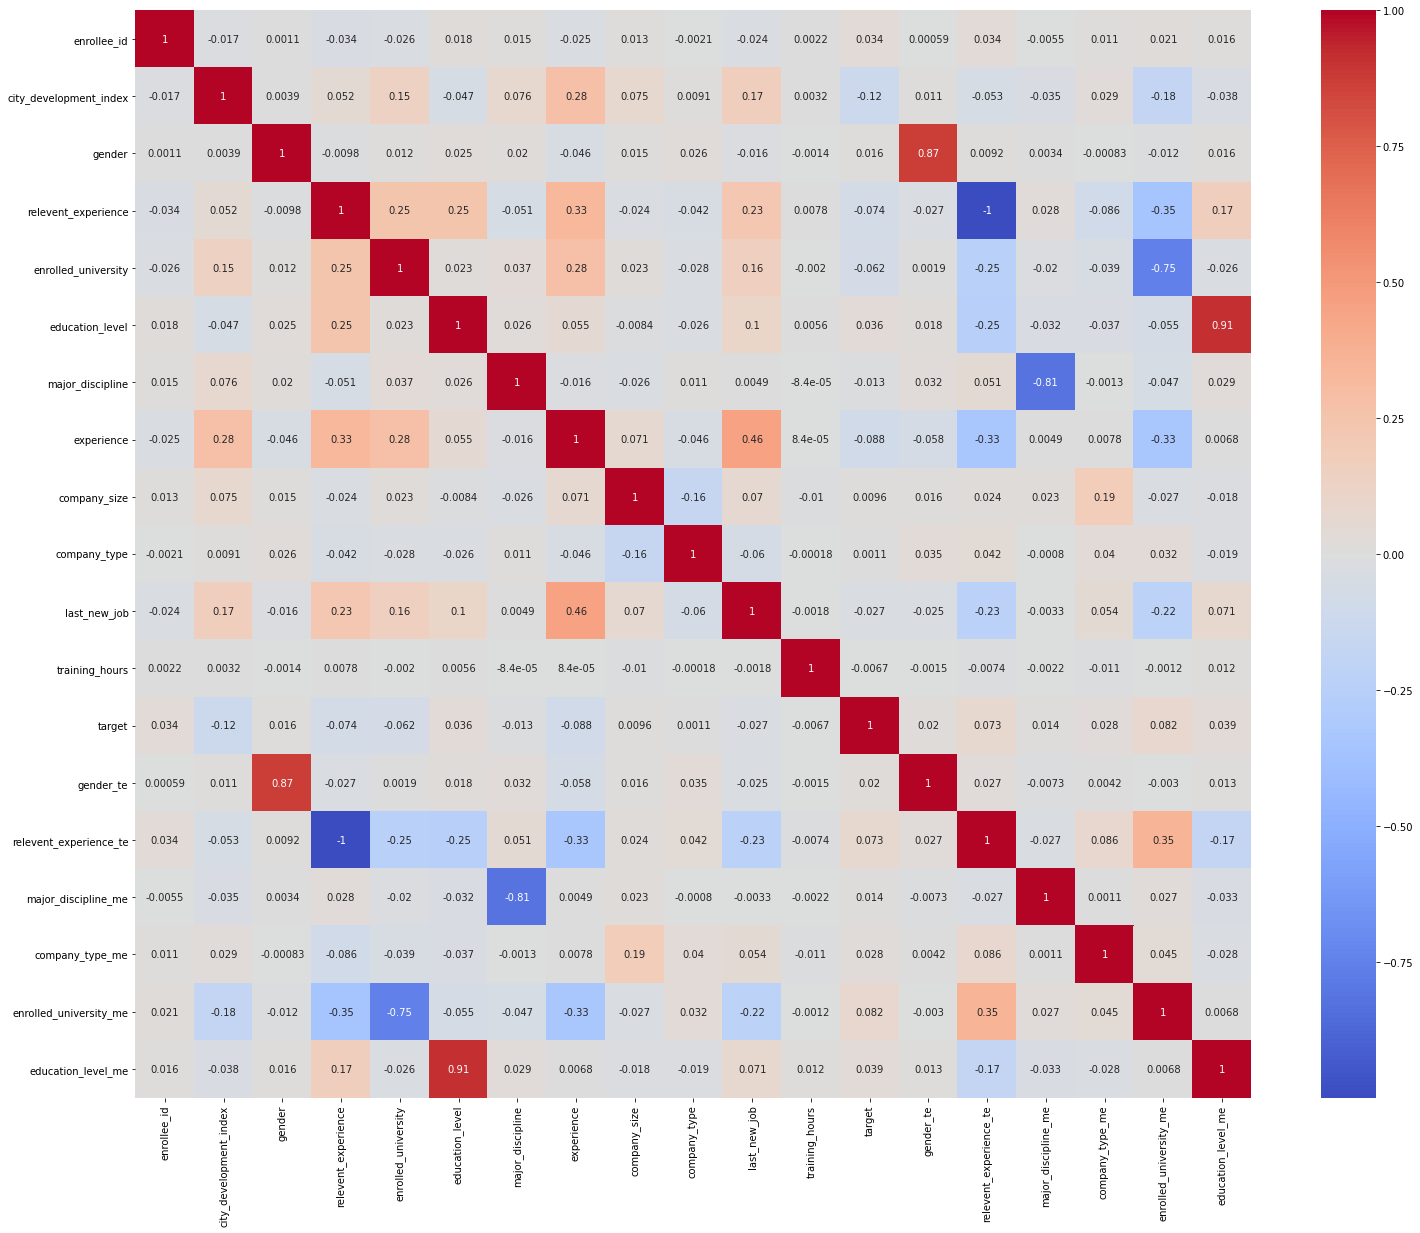

In [427]:
plt.subplots(figsize=(25,20))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')

In [428]:
def feature_importance(model, X_train):

    fI = model.feature_importances_
    
    print(fI)
    
    names = X_train.columns.values
    
    ticks = [i for i in range(len(names))]
    
    plt.bar(ticks, fI)
    
    plt.xticks(ticks, names,rotation = 90)
    
    plt.show()

In [429]:
train['city'] = train['city'].astype(int)
test['city'] = test['city'].astype(int)
test_id = test['enrollee_id']
final_test = test.drop(columns=['enrollee_id', 'city'], axis=1)
y = train['target']
X = train.drop(columns=['enrollee_id', 'target', 'city'], axis=1)

In [430]:
X.dtypes

city_development_index    float64
gender                      int64
relevent_experience         int64
enrolled_university         int64
education_level             int64
major_discipline            int64
experience                  int64
company_size                int64
company_type                int64
last_new_job                int64
training_hours            float64
gender_te                 float64
relevent_experience_te    float64
major_discipline_me       float64
company_type_me           float64
enrolled_university_me    float64
education_level_me        float64
dtype: object

In [431]:
final_test.dtypes

city_development_index    float64
gender                      int64
relevent_experience         int64
enrolled_university         int64
education_level             int64
major_discipline            int64
experience                  int64
company_size                int64
company_type                int64
last_new_job                int64
training_hours            float64
gender_te                 float64
relevent_experience_te    float64
major_discipline_me       float64
company_type_me           float64
enrolled_university_me    float64
education_level_me        float64
dtype: object

 
####################################################################################################
Seed 1
Fold 0
Rows of Train=  12851 Rows of Holdout =  5508
[0]	validation_0-auc:0.57225	validation_0-logloss:0.66666
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.62271	validation_0-logloss:0.37875
Stopping. Best iteration:
[95]	validation_0-auc:0.62477	validation_0-logloss:0.37836

ROC_AUC=  0.6247662248839028
####################################################################################################
[0.11883986 0.03670065 0.09972338 0.04652078 0.06104533 0.03773234
 0.06877897 0.04632149 0.0358343  0.05039691 0.05279158 0.05509435
 0.06264608 0.05391494 0.05517431 0.05673997 0.06174473]


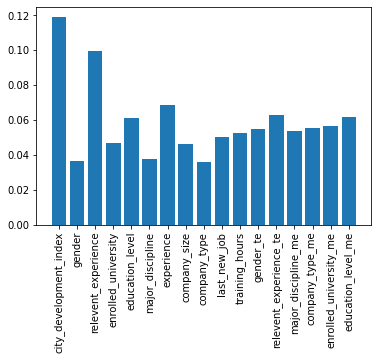

Fold 1
Rows of Train=  12851 Rows of Holdout =  5508
[0]	validation_0-auc:0.57061	validation_0-logloss:0.66674
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.62218	validation_0-logloss:0.37891
Stopping. Best iteration:
[95]	validation_0-auc:0.62279	validation_0-logloss:0.37875

ROC_AUC=  0.6227944388247735
####################################################################################################
Fold 2
Rows of Train=  12851 Rows of Holdout =  5508
[0]	validation_0-auc:0.58107	validation_0-logloss:0.66658
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.63147	validation_0-logloss:0.37709
Stopping. Best iteration:
[119]	validation_0-auc:0.63366	validation_0-logloss:0.37672

ROC_AUC=  0.6336607430226

In [432]:
# XGBoost Classifier
probs = np.zeros(shape=(len(final_test)))
scores = []
avg_loss = []

X_train, y_train = X, y
seeds = [1]

for seed in tnrange(len(seeds)):
    print(' ')
    print('#'*100)
    print('Seed', seeds[seed])
    sf = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=seed)
    for i, (idxT, idxV) in enumerate(sf.split(X_train, y_train)):
        print('Fold', i)
        print('Rows of Train= ', len(idxT), 'Rows of Holdout = ', len(idxV))
        clf = XGBClassifier(n_estimators=1000,
                           max_depth=6,
                           learning_rate=0.05,
                            subsample=0.9,
                            colsample_bytree=0.35,
                            objective='binary:logistic',
                            random_state=1)
        preds = clf.fit(X_train.iloc[idxT], y_train.iloc[idxT],
                       eval_set=[(X_train.iloc[idxV], y_train.iloc[idxV])],
                       verbose=100, eval_metric=['auc', 'logloss'],
                       early_stopping_rounds=50)
        probs_oof = clf.predict_proba(X_train.iloc[idxV])[:,1]
        probs += clf.predict_proba(final_test)[:,1]
        roc = roc_auc_score(y_train.iloc[idxV], probs_oof)
        scores.append(roc)
        avg_loss.append(clf.best_score)
        print("ROC_AUC= ", roc)
        print('#'*100)
        if i==0:
            feature_importance(clf,X_train)
        
print("Loss= {0:0.5f}, {1:0.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))
print('%.6f (%.6f)' % (np.array(scores).mean(), np.array(scores).std()))

 
####################################################################################################
Seed 1
Fold 0
Rows of Train=  12851 Rows of Holdout =  5508
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's auc: 0.622122	valid_0's binary_logloss: 0.378989
ROC_AUC=  0.6221215630603706
####################################################################################################
[ 95   5  10  15  24   4  68  43   4  37  58  93  55  75  77  73 117]


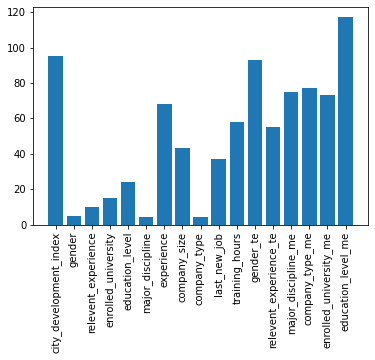

Fold 1
Rows of Train=  12851 Rows of Holdout =  5508
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.630835	valid_0's binary_logloss: 0.3786
ROC_AUC=  0.6308350383925698
####################################################################################################
Fold 2
Rows of Train=  12851 Rows of Holdout =  5508
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's auc: 0.637184	valid_0's binary_logloss: 0.385381
ROC_AUC=  0.6371837498275784
####################################################################################################
Fold 3
Rows of Train=  12851 Rows of Holdout =  5508
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's auc: 0.615411	valid_0's binary_logloss: 0.38233
ROC_AUC=  0.615411484436066
#############################################################################

<ipython-input-433-06c74e5eff57>:41: RuntimeWarning: Mean of empty slice.
  print("Loss= {0:0.5f}, {1:0.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [433]:
# LGBM Classifier
probs_lgbm = np.zeros(shape=(len(final_test)))
scores = []
avg_loss = []

#oversample = SMOTE()
#X_smote, y_smote = oversample.fit_resample(X, y)
#X_train, y_train = X_smote, y_smote
X_train, y_train = X, y
seeds = [1]

for seed in tnrange(len(seeds)):
    print(' ')
    print('#'*100)
    print('Seed', seeds[seed])
    sf = StratifiedShuffleSplit(n_splits=4, test_size=0.3, random_state=seed)
    for i, (idxT, idxV) in enumerate(sf.split(X_train, y_train)):
        print('Fold', i)
        print('Rows of Train= ', len(idxT), 'Rows of Holdout = ', len(idxV))
        clf = LGBMClassifier(boosting_type='gbdt',
                       max_depth=5,
                       learning_rate=0.05,
                       n_estimators=5000,
                       min_child_weight=0.01,
                       colsample_bytree=0.5,
                       random_state=1994)
        preds = clf.fit(X_train.iloc[idxT], y_train.iloc[idxT],
                       eval_set=[(X_train.iloc[idxV], y_train.iloc[idxV])],
                       verbose=100, eval_metric=['auc', 'logloss'],
                       early_stopping_rounds=50)
        probs_oof = clf.predict_proba(X_train.iloc[idxV])[:,1]
        probs_lgbm += clf.predict_proba(final_test)[:,1]
        roc = roc_auc_score(y_train.iloc[idxV], probs_oof)
        scores.append(roc)
        #avg_loss.append(clf.best_score)
        print("ROC_AUC= ", roc)
        print('#'*100)
        if i==0:
            feature_importance(clf,X_train)
        
print("Loss= {0:0.5f}, {1:0.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))
print('%.6f (%.6f)' % (np.array(scores).mean(), np.array(scores).std()))

 
####################################################################################################
Seed 1
Fold 0
Rows of Train=  12851 Rows of Holdout =  5508
0:	learn: 0.6723158	test: 0.6723591	best: 0.6723591 (0)	total: 23.3ms	remaining: 1m 56s
100:	learn: 0.3704288	test: 0.3790638	best: 0.3790638 (100)	total: 606ms	remaining: 29.4s
200:	learn: 0.3609942	test: 0.3781292	best: 0.3781215 (198)	total: 1.34s	remaining: 32s
300:	learn: 0.3532384	test: 0.3780550	best: 0.3778818 (283)	total: 1.9s	remaining: 29.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3778817977
bestIteration = 283

Shrink model to first 284 iterations.
ROC_AUC=  0.6251905260011955
####################################################################################################
[18.24627754  1.53476478  5.94178112  3.30726059  6.95916736  2.23477926
  7.87005912  5.38609126  2.67229319  7.73683735  5.16131109  6.89819692
  5.4688834   4.87662106  5.04253881  5.03425355  5.6288836 ]


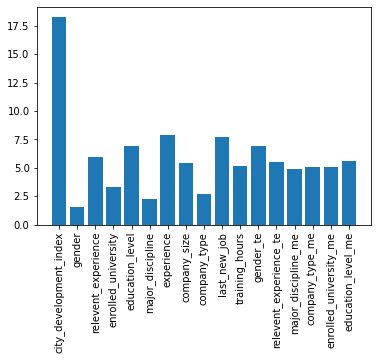

Fold 1
Rows of Train=  12851 Rows of Holdout =  5508
0:	learn: 0.6722907	test: 0.6723898	best: 0.6723898 (0)	total: 8.58ms	remaining: 42.9s
100:	learn: 0.3705031	test: 0.3784913	best: 0.3784913 (100)	total: 574ms	remaining: 27.9s
200:	learn: 0.3615380	test: 0.3774051	best: 0.3772714 (172)	total: 1.15s	remaining: 27.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3772714416
bestIteration = 172

Shrink model to first 173 iterations.
ROC_AUC=  0.632492873235551
####################################################################################################
Fold 2
Rows of Train=  12851 Rows of Holdout =  5508
0:	learn: 0.6722649	test: 0.6723103	best: 0.6723103 (0)	total: 5.44ms	remaining: 27.2s
100:	learn: 0.3709002	test: 0.3781849	best: 0.3781849 (100)	total: 629ms	remaining: 30.5s
200:	learn: 0.3615656	test: 0.3767530	best: 0.3767439 (182)	total: 1.18s	remaining: 28.3s
300:	learn: 0.3544307	test: 0.3766124	best: 0.3765989 (267)	total: 1.9s	remaining: 29.6s
400:

<ipython-input-434-2048bbde5ab0>:35: RuntimeWarning: Mean of empty slice.
  print("Loss= {0:0.5f}, {1:0.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [434]:
# CatBoost Classifier
probs_cat = np.zeros(shape=(len(final_test)))
scores = []
avg_loss = []

X_train, y_train = X, y
seeds = [1]

for seed in tnrange(len(seeds)):
    print(' ')
    print('#'*100)
    print('Seed', seeds[seed])
    sf = StratifiedShuffleSplit(n_splits=4, test_size=0.3, random_state=seed)
    for i, (idxT, idxV) in enumerate(sf.split(X_train, y_train)):
        print('Fold', i)
        print('Rows of Train= ', len(idxT), 'Rows of Holdout = ', len(idxV))
        clf = CatBoostClassifier(n_estimators=5000,
                           random_state=1994,
                           #eval_metric='AUC',
                           learning_rate=0.03, max_depth=5)
        preds = clf.fit(X_train.iloc[idxT], y_train.iloc[idxT],
                       eval_set=[(X_train.iloc[idxV], y_train.iloc[idxV])],
                       verbose=100,
                       early_stopping_rounds=50)
        probs_oof = clf.predict_proba(X_train.iloc[idxV])[:,1]
        probs_cat += clf.predict_proba(final_test)[:,1]
        roc = roc_auc_score(y_train.iloc[idxV], probs_oof)
        scores.append(roc)
        #avg_loss.append(clf.best_score)
        print("ROC_AUC= ", roc)
        print('#'*100)
        if i==0:
            feature_importance(clf,X_train)
        
print("Loss= {0:0.5f}, {1:0.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))
print('%.6f (%.6f)' % (np.array(scores).mean(), np.array(scores).std()))

In [435]:
sample = pd.read_csv("../data/sample.csv")
sample['enrollee_id'] = test_id
sample['target'] = ((probs_cat)/4+(probs)/4+(probs_lgbm)/4)/3
#sample['target'] = (probs_lgbm)/4
sample.to_csv('submission7.csv',index =False)